# Data Analysis Cycle

<img src='./img/DataAnalysis_CycleTS0.png' width='800'>

<img src='./img/DataAnalysis_Cycle1.png' width='800'>

<img src='./img/DataAnalysis_CycleTS1.png' width='800'>

<img src='./img/DataAnalysis_CycleTS3.png' width='800'>

<img src='./img/DataAnalysis_CycleTS4.png' width='800'>

<img src='./img/DataAnalysis_CycleTS2.png' width='800'>

<img src='./img/DataAnalysis_CycleTS5.png' width='800'>

<img src='./img/DataAnalysis_Cycle4.png' width='800'>

<img src='./img/DataAnalysis_Cycle5.png' width='800'>

<img src='./img/DataAnalysis_Cycle6.png' width='800'>

<img src='./img/DataAnalysis_Cycle7.png' width='800'>

<img src='./img/DataAnalysis_Cycle8.png' width='800'>

<img src='./img/DataAnalysis_Cycle9.png' width='800'>


# **Import Library:** 분석에 사용할 모듈 설치

In [2]:
# !pip install --upgrade pip
# !python -m pip install --user --upgrade pip

In [4]:
# Ignore the warnings
import warnings
# warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# System related and data input controls
import os

# Data manipulation and visualization
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 20
pd.options.display.max_columns = 20
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from tqdm import tqdm

# Modeling algorithms
# General
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

# Model selection
from sklearn.model_selection import train_test_split

# Evaluation metrics
from sklearn import metrics
# for regression
from sklearn.metrics import mean_squared_error,  mean_absolute_error, mean_absolute_percentage_error

## 분석가 정의 함수

In [6]:
# 시계열 변수추출
## 날짜인식 및 빈도 설정만
def non_feature_engineering(df):
    df_nfe = df.copy()
    if 'datetime' in df_nfe.columns:
        df_nfe['datetime'] = pd.to_datetime(df_nfe['datetime'])
        df_nfe['DateTime'] = pd.to_datetime(df_nfe['datetime'])
    if df_nfe.index.dtype == 'int64':
        df_nfe.set_index('DateTime', inplace=True)
    df_nfe = df_nfe.asfreq('H', method='ffill')

    return df_nfe


## 날짜인식 및 빈도 설정을 포함한 모든 전처리
def feature_engineering(df):
    df_fe = df.copy()
    if 'datetime' in df_fe.columns:
        df_fe['datetime'] = pd.to_datetime(df_fe['datetime'])
        df_fe['DateTime'] = pd.to_datetime(df_fe['datetime'])

    if df_fe.index.dtype == 'int64':
        df_fe.set_index('DateTime', inplace=True)

    df_fe = df_fe.asfreq('H', method='ffill')

    result = sm.tsa.seasonal_decompose(df_fe['count'], model='additive')
    Y_trend = pd.DataFrame(result.trend)
    Y_trend.fillna(method='ffill', inplace=True)
    Y_trend.fillna(method='bfill', inplace=True)
    Y_trend.columns = ['count_trend']
    Y_seasonal = pd.DataFrame(result.seasonal)
    Y_seasonal.fillna(method='ffill', inplace=True)
    Y_seasonal.fillna(method='bfill', inplace=True)
    Y_seasonal.columns = ['count_seasonal']
    pd.concat([df_fe, Y_trend, Y_seasonal], axis=1).isnull().sum()
    if 'count_trend' not in df_fe.columns:
        if 'count_seasonal' not in df_fe.columns:
            df_fe = pd.concat([df_fe, Y_trend, Y_seasonal], axis=1)

    Y_count_Day = df_fe[['count']].rolling(24).mean()
    Y_count_Day.fillna(method='ffill', inplace=True)
    Y_count_Day.fillna(method='bfill', inplace=True)
    Y_count_Day.columns = ['count_Day']
    Y_count_Week = df_fe[['count']].rolling(24*7).mean()
    Y_count_Week.fillna(method='ffill', inplace=True)
    Y_count_Week.fillna(method='bfill', inplace=True)
    Y_count_Week.columns = ['count_Week']
    if 'count_Day' not in df_fe.columns:
        df_fe = pd.concat([df_fe, Y_count_Day], axis=1)
    if 'count_Week' not in df_fe.columns:
        df_fe = pd.concat([df_fe, Y_count_Week], axis=1)

    Y_diff = df_fe[['count']].diff()
    Y_diff.fillna(method='ffill', inplace=True)
    Y_diff.fillna(method='bfill', inplace=True)
    Y_diff.columns = ['count_diff']
    if 'count_diff' not in df_fe.columns:
        df_fe = pd.concat([df_fe, Y_diff], axis=1)

#     df_fe['temp_group'] = pd.cut(df_fe['temp'], 10)
    df_fe['Year'] = df_fe.datetime.dt.year
    df_fe['Quater'] = df_fe.datetime.dt.quarter
    df_fe['Quater_ver2'] = df_fe['Quater'] + (df_fe.Year - df_fe.Year.min()) * 4
    df_fe['Month'] = df_fe.datetime.dt.month
    df_fe['Day'] = df_fe.datetime.dt.day
    df_fe['Hour'] = df_fe.datetime.dt.hour
    df_fe['DayofWeek'] = df_fe.datetime.dt.dayofweek

    df_fe['count_lag1'] = df_fe['count'].shift(1)
    df_fe['count_lag2'] = df_fe['count'].shift(2)
    df_fe['count_lag1'].fillna(method='bfill', inplace=True)
    df_fe['count_lag2'].fillna(method='bfill', inplace=True)

    if 'Quater' in df_fe.columns:
        if 'Quater_Dummy' not in ['_'.join(col.split('_')[:2]) for col in df_fe.columns]:
            df_fe = pd.concat([df_fe, pd.get_dummies(df_fe['Quater'], prefix='Quater_Dummy', drop_first=True)], axis=1)
            del df_fe['Quater']
    
    return df_fe


# 데이터 분리
## cross sectional 데이터
def datasplit(df, Y_colname, test_size=0.2, random_state=123):
    X_colname = [x for x in df.columns if x not in Y_colname]
       
    X_train, X_test, Y_train, Y_test = train_test_split(df[X_colname], df[Y_colname],
                                                        test_size=test_size, random_state=random_state)
    print(X_train.shape, Y_train.shape)
    print(X_test.shape, Y_test.shape)
    
    return X_train, X_test, Y_train, Y_test


## time series 데이터
def datasplit_ts(df, Y_colname, X_colname, criteria):
    df_train = df.loc[df.index < criteria,:]
    df_test = df.loc[df.index >= criteria,:]
    Y_train = df_train[Y_colname]
    X_train = df_train[X_colname]
    Y_test = df_test[Y_colname]
    X_test = df_test[X_colname]
    print('Train_size:', df_train.shape, 'Test_size:', df_test.shape)
    print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
    print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)
    
    return X_train, X_test, Y_train, Y_test


# 실제 Y와 예측치 시각화
def plot_prediction(Y_true_pred):
    plt.figure(figsize=(16, 8))
    plt.plot(Y_true_pred, linewidth=5, label=Y_true_pred.columns)
    plt.xticks(fontsize=25, rotation=0)
    plt.yticks(fontsize=25)
    plt.xlabel('Index', fontname='serif', fontsize=28)
    plt.legend(fontsize=20)
    plt.grid()
    plt.show()
    
    
# 검증 함수화
def evaluation_reg(Y_real, Y_pred):
    MAE = mean_absolute_error(Y_real, Y_pred)
    MSE = mean_squared_error(Y_real, Y_pred)
    MAPE = mean_absolute_percentage_error(Y_real, Y_pred)
    Score = pd.DataFrame([MAE, MSE, MAPE], index=['MAE', 'MSE', 'MAPE'], columns=['Score']).T
    
    return Score

# Train & Test 모두의 검증 함수화
def evaluation_reg_trte(Y_real_tr, Y_pred_tr, Y_real_te, Y_pred_te):
    Score_tr = evaluation_reg(Y_real_tr, Y_pred_tr)
    Score_te = evaluation_reg(Y_real_te, Y_pred_te)
    Score_trte = pd.concat([Score_tr, Score_te], axis=0)
    Score_trte.index = ['Train', 'Test']

    return Score_trte


# 에러 분석
def error_analysis_timeseries(X_Data, Y_Pred, Residual, graph_on=False):
    # Setting
    Resid = Residual.copy()
    if Resid.shape[0] >= 100:
        lag_max = 50
    else:
        lag_max = int(Resid.shape[0]/2)-1
        
    if graph_on == True:
        ##### 시각화
        # index를 별도 변수로 저장 
        Resid = Residual.copy()
        Resid['Index'] = Resid.reset_index().index
    
        # 잔차의 정규분포성 확인
        sns.distplot(Resid.iloc[:,[0]], norm_hist='True', fit=stats.norm)
        plt.show()

        # 잔차의 등분산성 확인
        # sns.lmplot(data=Resid, x='Index', y=Resid.columns[0],
        #            fit_reg=True, line_kws={'color': 'red'}, size=5, aspect=2, ci=99, sharey=True)
        sns.lmplot(data=Resid, x='Index', y=Resid.columns[0],
                   fit_reg=True, line_kws={'color': 'red'}, aspect=2, ci=99, sharey=True)
        plt.show()
        
        # 잔차의 자기상관성 확인
        sm.graphics.tsa.plot_acf(Resid.iloc[:,[0]], lags=lag_max, use_vlines=True)
        plt.ylabel('Correlation')
        plt.show()
        
        # 잔차의 편자기상관성 확인
        sm.graphics.tsa.plot_pacf(Resid.iloc[:,[0]], lags=lag_max, use_vlines=True)
        plt.ylabel('Correlation')
        plt.show()

    ##### 통계량
    # 정규분포
    # Null Hypothesis: The residuals are normally distributed
    Normality = pd.DataFrame([stats.shapiro(Residual)], 
                             index=['Normality'], columns=['Test Statistics', 'p-value']).T

    # 등분산성
    # Null Hypothesis: Error terms are homoscedastic
    Heteroscedasticity = pd.DataFrame([sm.stats.diagnostic.het_goldfeldquandt(Residual, X_Data.values, alternative='two-sided')],
                                      index=['Heteroscedasticity'], 
                                      columns=['Test Statistics', 'p-value', 'Alternative']).T
    
    # 자기상관
    # Null Hypothesis: Autocorrelation is absent
    Autocorrelation = pd.concat([pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Residual, lags=[10,lag_max]).iloc[:,0]),
                             pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Residual, lags=[10,lag_max]).iloc[:,1])], axis=1).T
    Autocorrelation.index = ['Test Statistics', 'p-value']
    Autocorrelation.columns = ['Autocorr(lag10)', 'Autocorr(lag50)']
    
    # 정상성
    # ADF
    # Null Hypothesis: The Time-series is non-stationalry
    Stationarity = pd.Series(sm.tsa.stattools.adfuller(Residual)[0:3], 
                             index=['Test Statistics', 'p-value', 'Used Lag'])
    for key, value in sm.tsa.stattools.adfuller(Resid.iloc[:,[0]])[4].items():
        Stationarity['Critical Value(%s)'%key] = value
    Stationarity_ADF = pd.DataFrame(Stationarity, columns=['Stationarity_ADF'])
    # KPSS
    # Null Hypothesis: The Time-series is stationalry
    Stationarity = pd.Series(sm.tsa.stattools.kpss(Residual)[0:3], 
                             index=['Test Statistics', 'p-value', 'Used Lag'])
    for key, value in sm.tsa.stattools.kpss(Resid.Error)[3].items():
        if key != '2.5%':
            Stationarity['Critical Value(%s)'%key] = value
    Stationarity_KPSS = pd.DataFrame(Stationarity, columns=['Stationarity_KPSS'])
    
    Error_Analysis = pd.concat([Normality, Heteroscedasticity, Autocorrelation,
                                Stationarity_ADF, Stationarity_KPSS], join='outer', axis=1)
    
    return Error_Analysis

# **Base Algorithm:** 분석결과

In [7]:
# # Colab에서 실행
# # 아래 코드 실행 후 파일 선택을 눌러서 
# # 'Bike_Sharing_Demand_Full.csv' 파일을 선택해주면 로딩 완료
# from google.colab import files
# files.upload()

# # 아래 코드 실행 시 'Bike_Sharing_Demand_Full.csv' 데이터 출력 가능
# import pandas as pd
# df = pd.read_csv('Bike_Sharing_Demand_Full.csv')
# df

## 전처리 미반영 분석결과

Train_size: (13128, 12) Test_size: (4416, 12)
X_train: (13128, 8) Y_train: (13128, 1)
X_test: (4416, 8) Y_test: (4416, 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  count   R-squared (uncentered):                   0.638
Model:                            OLS   Adj. R-squared (uncentered):              0.638
Method:                 Least Squares   F-statistic:                              2889.
Date:                Sat, 29 Apr 2023   Prob (F-statistic):                        0.00
Time:                        00:56:43   Log-Likelihood:                         -83421.
No. Observations:               13128   AIC:                                  1.669e+05
Df Residuals:                   13120   BIC:                                  1.669e+05
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
season         3.3659      1.286      2.618      0.009       0.846       5.886
holiday       -6.2896      7.466     -0.842      0.400     -20.924       8.345
workingday    10.3553      2.641      3.921      0.000       5.178      15.533
weather        7.1906      2.093      3.436      0.001       3.089      11.292
temp          -7.8544      1.222     -6.429      0.000     -10.249      -5.460
atemp         16.0695      1.095     14.676      0.000      13.923      18.216
humidity      -1.7353      0.063    -27.356      0.000      -1.860      -1.611
windspeed      2.2749      0.136     16.745      0.000       2.009       2.541
==============================================================================
Omnibus:                     2168.771   Durbin-Watson:                   0.419
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3942.747
Skew:                           1.050   Prob(JB):                         0.00
Kurtosis:                       4.672   Cond. No.                         450.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

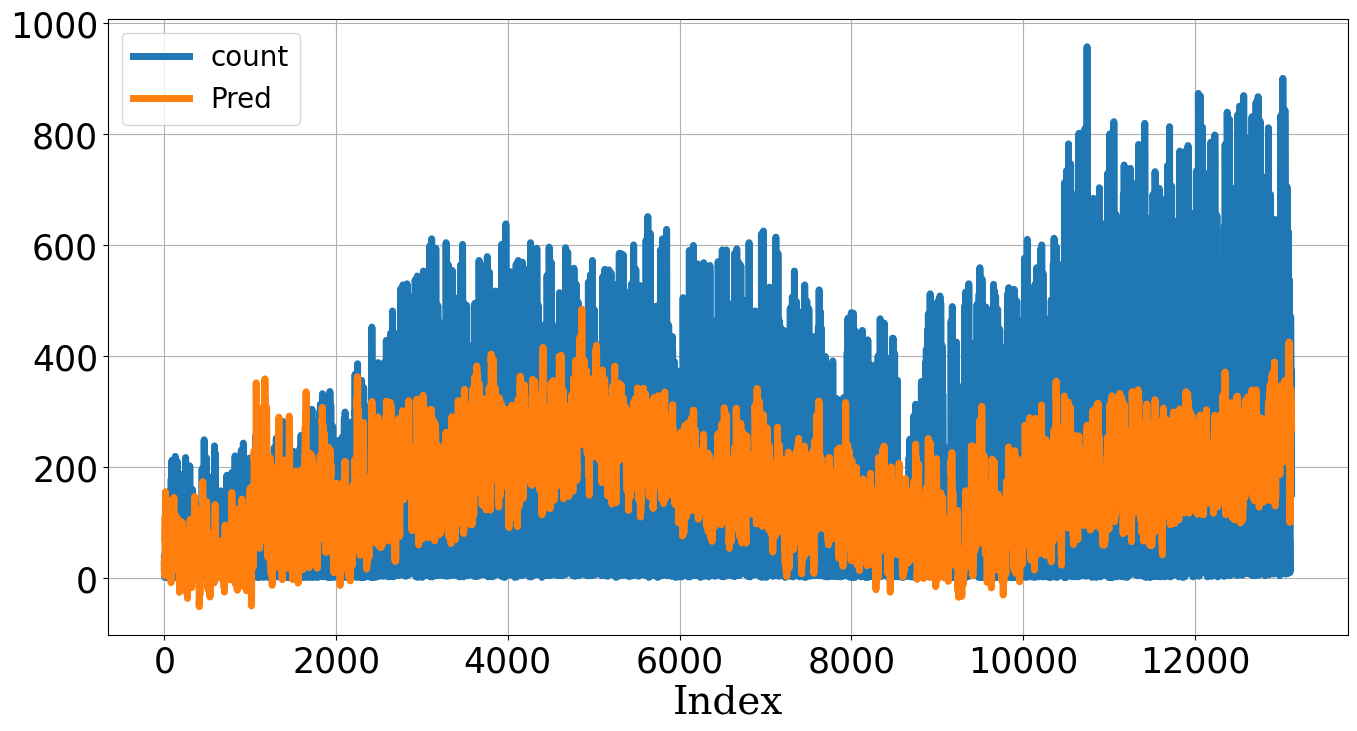

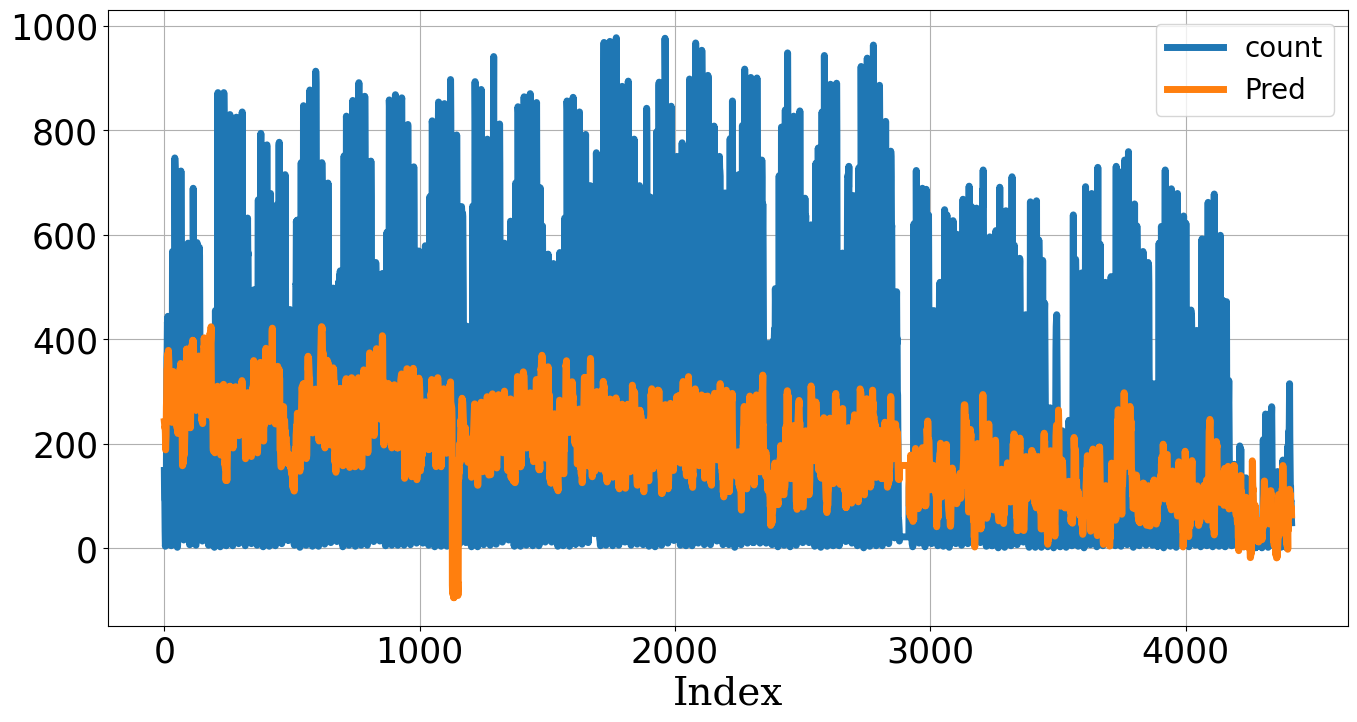

,MAE,MSE,MAPE
Train,103.09,"19,360.42",4.58
Test,150.03,"43,410.27",3.17


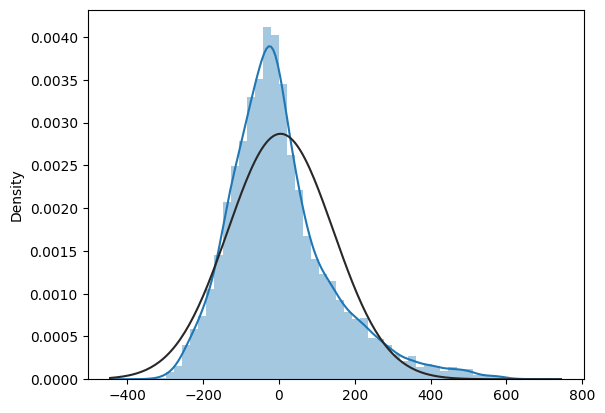

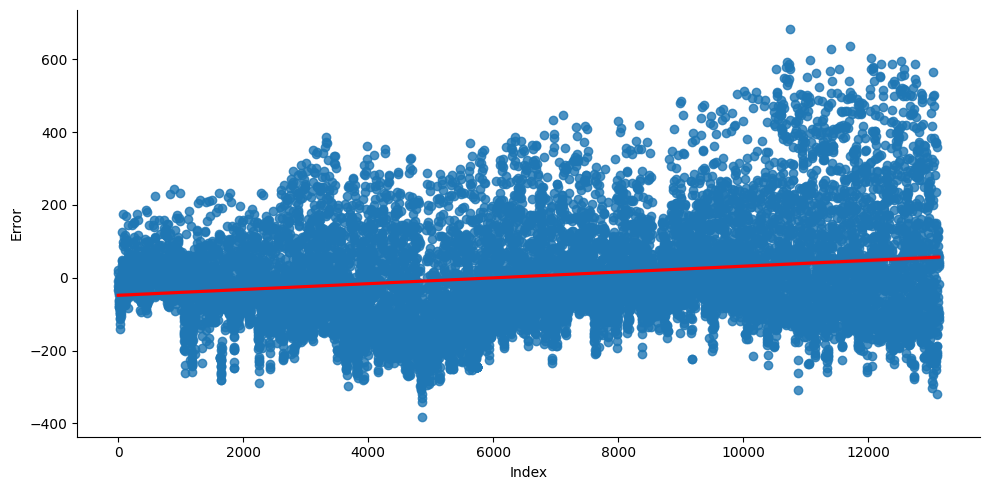

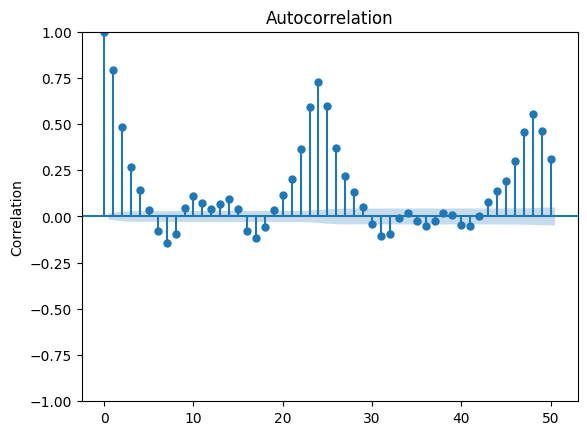

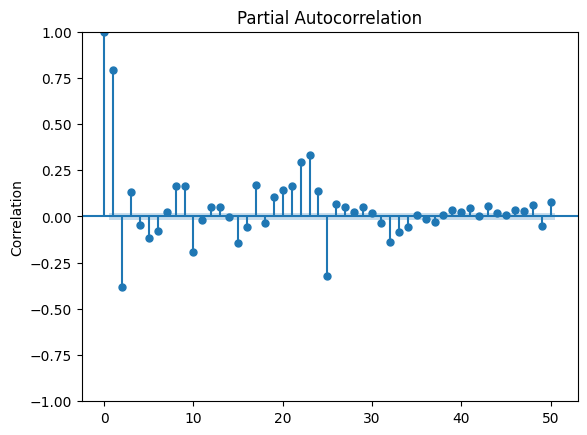

,Normality,Heteroscedasticity,Autocorr(lag10),Autocorr(lag50),Stationarity_ADF,Stationarity_KPSS
Test Statistics,0.94,1.76,"13,138.03","48,485.56",-9.25,19.30
p-value,0.00,0.00,0.00,0.00,0.00,0.01
Alternative,NaN,two-sided,NaN,NaN,NaN,NaN
Used Lag,NaN,NaN,NaN,NaN,40.00,18.00
Critical Value(1%),NaN,NaN,NaN,NaN,-3.43,0.74
Critical Value(5%),NaN,NaN,NaN,NaN,-2.86,0.46
Critical Value(10%),NaN,NaN,NaN,NaN,-2.57,0.35


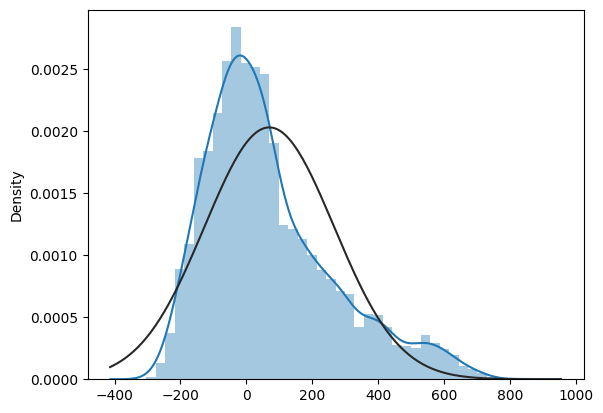

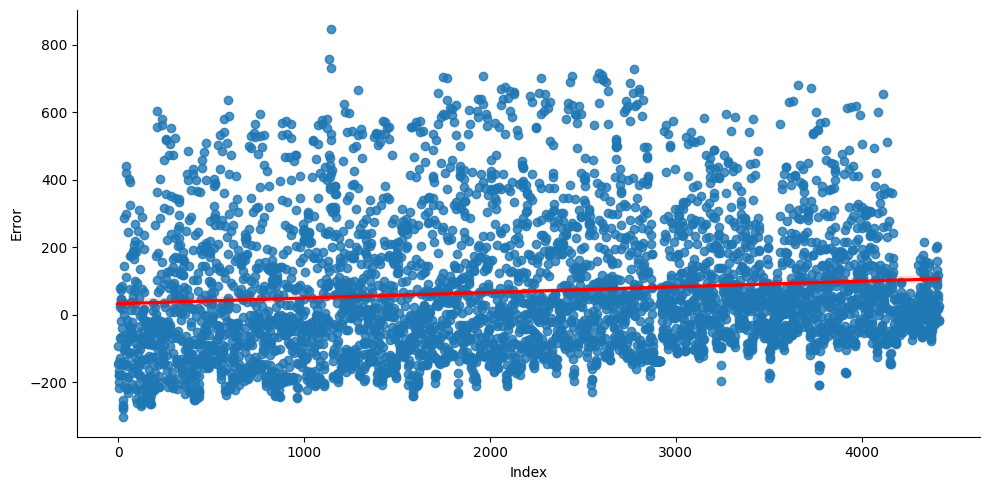

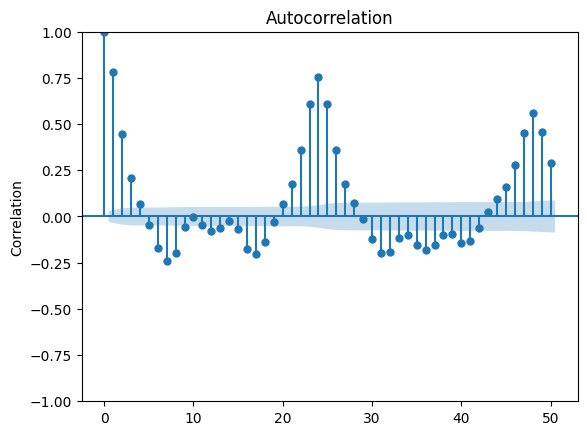

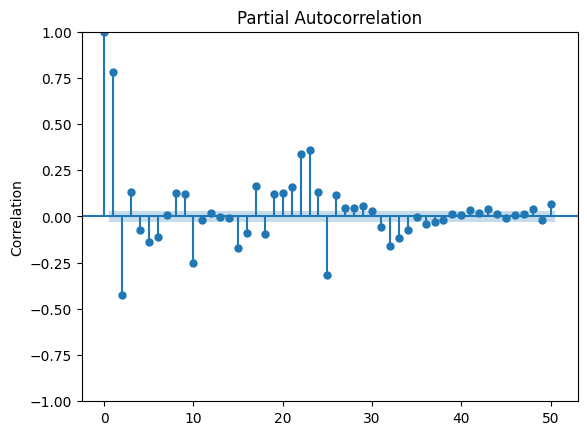

,Normality,Heteroscedasticity,Autocorr(lag10),Autocorr(lag50),Stationarity_ADF,Stationarity_KPSS
Test Statistics,0.93,0.73,"4,400.21","17,427.07",-6.11,2.62
p-value,0.00,0.00,0.00,0.00,0.00,0.01
Alternative,NaN,two-sided,NaN,NaN,NaN,NaN
Used Lag,NaN,NaN,NaN,NaN,31.00,15.00
Critical Value(1%),NaN,NaN,NaN,NaN,-3.43,0.74
Critical Value(5%),NaN,NaN,NaN,NaN,-2.86,0.46
Critical Value(10%),NaN,NaN,NaN,NaN,-2.57,0.35


In [8]:
# 데이터 로딩
location = os.path.join('.', 'data', 'Bike_Sharing_Demand_Full.csv')
df_all = pd.read_csv(location)

# 데이터 전처리
df_fe = non_feature_engineering(df_all)

# 데이터 분리
Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in df_fe.columns if x not in Y_colname+X_remove]
X_train, X_test, Y_train, Y_test = datasplit_ts(df_fe, Y_colname, X_colname, '2012-07-01')

# Linear Regression
model_lr_Raw = sm.OLS(Y_train, X_train).fit()
display(model_lr_Raw.summary())

Y_trpred = pd.DataFrame(model_lr_Raw.predict(X_train), columns=['Pred'])
Y_tepred = pd.DataFrame(model_lr_Raw.predict(X_test), columns=['Pred'])
plot_prediction(pd.concat([Y_train, Y_trpred], axis=1).reset_index().iloc[:,1:])
plot_prediction(pd.concat([Y_test, Y_tepred], axis=1).reset_index().iloc[:,1:])

# 분석 검증
Score_Raw = evaluation_reg_trte(Y_train, Y_trpred, Y_test, Y_tepred)
display(Score_Raw)

# 에러 분석
Resid_tr = Y_train - Y_trpred.values
Resid_tr.columns = ['Error']
Resid_te = Y_test - Y_tepred.values
Resid_te.columns = ['Error']

Error_tr = error_analysis_timeseries(X_train, Y_trpred, Resid_tr, graph_on=True)
display(Error_tr)
Error_te = error_analysis_timeseries(X_test, Y_tepred, Resid_te, graph_on=True)
display(Error_te)

## 전처리 반영 분석결과

Train_size: (13128, 28) Test_size: (4416, 28)
X_train: (13128, 24) Y_train: (13128, 1)
X_test: (4416, 24) Y_test: (4416, 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.362e+08
Date:                Sat, 29 Apr 2023   Prob (F-statistic):               0.00
Time:                        00:57:25   Log-Likelihood:                 1906.2
No. Observations:               13128   AIC:                            -3764.
Df Residuals:                   13104   BIC:                            -3585.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
season            -0.0005      0.004     -0.129      0.897      -0.009       0.008
holiday            0.0083      0.014      0.612      0.540      -0.018       0.035
workingday         0.0079      0.007      1.184      0.236      -0.005       0.021
weather            0.0042      0.003      1.232      0.218      -0.003       0.011
temp               0.0022      0.002      1.075      0.282      -0.002       0.006
atemp             -0.0025      0.002     -1.347      0.178      -0.006       0.001
humidity          -0.0001      0.000     -0.845      0.398      -0.000       0.000
windspeed          0.0003      0.000      1.062      0.288      -0.000       0.001
count_trend     9.161e-05   8.57e-05      1.069      0.285   -7.64e-05       0.000
count_seasonal  1.984e-05   2.56e-05      0.775      0.438   -3.03e-05       7e-05
count_Day       4.177e-05   8.36e-05      0.500      0.617      -0.000       0.000
count_Week     -4.345e-05   9.61e-05     -0.452      0.651      -0.000       0.000
count_diff         1.0000    2.9e-05   3.45e+04      0.000       1.000       1.000
Year           -1.547e-05   7.97e-06     -1.939      0.052   -3.11e-05    1.66e-07
Quater_ver2        0.0004      0.002      0.180      0.857      -0.004       0.005
Month              0.0026      0.002      1.051      0.293      -0.002       0.007
Day                0.0004      0.000      1.728      0.084   -4.91e-05       0.001
Hour               0.0006      0.000      1.538      0.124      -0.000       0.001
DayofWeek          0.0003      0.002      0.224      0.823      -0.003       0.003
count_lag1         1.0000    2.7e-05    3.7e+04      0.000       1.000       1.000
count_lag2     -1.926e-05   2.59e-05     -0.744      0.457      -7e-05    3.15e-05
Quater_Dummy_2    -0.0010      0.009     -0.115      0.909      -0.019       0.017
Quater_Dummy_3    -0.0037      0.017     -0.220      0.826      -0.037       0.030
Quater_Dummy_4    -0.0132      0.026     -0.512      0.609      -0.064       0.037
==============================================================================
Omnibus:                    54426.083   Durbin-Watson:                   1.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      93552024983.828
Skew:                        -114.255   Prob(JB):                         0.00
Kurtosis:                   13078.751   Cond. No.                     3.49e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.49e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

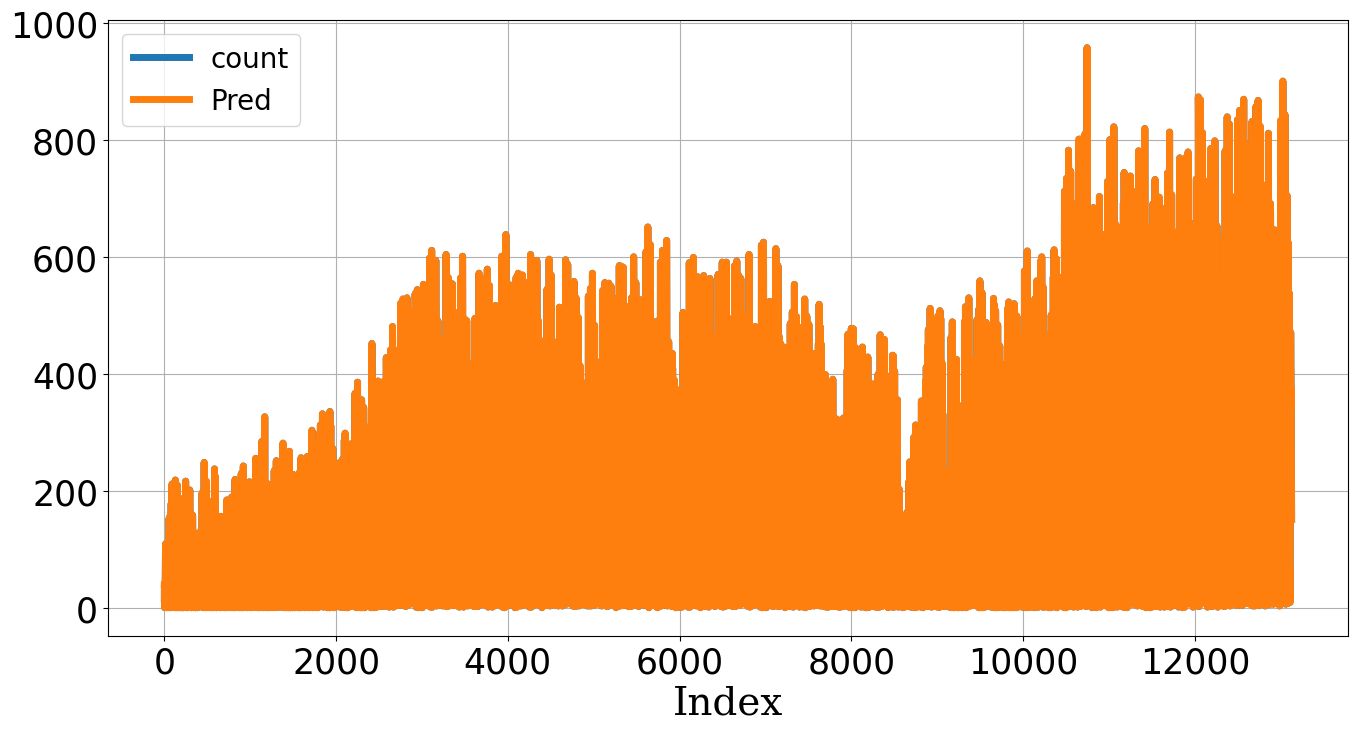

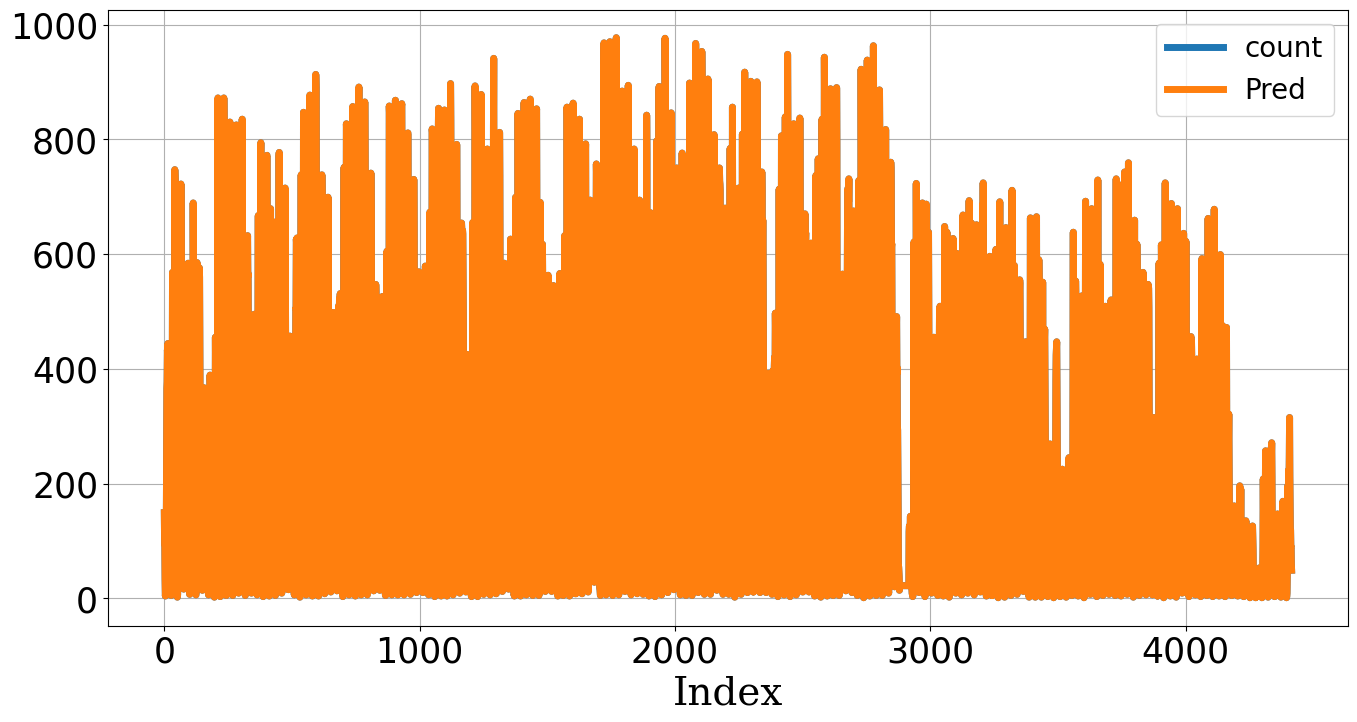

,MAE,MSE,MAPE
Train,0.01,0.04,0.00
Test,0.01,0.00,0.00


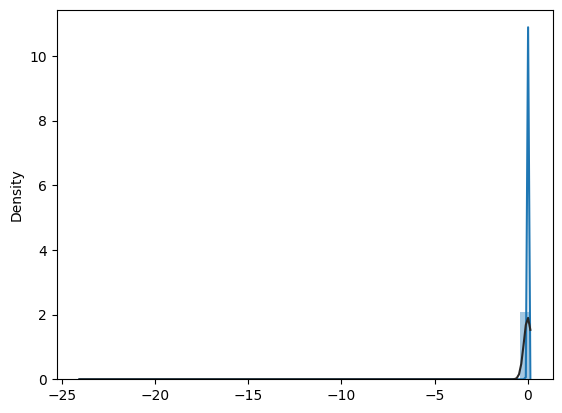

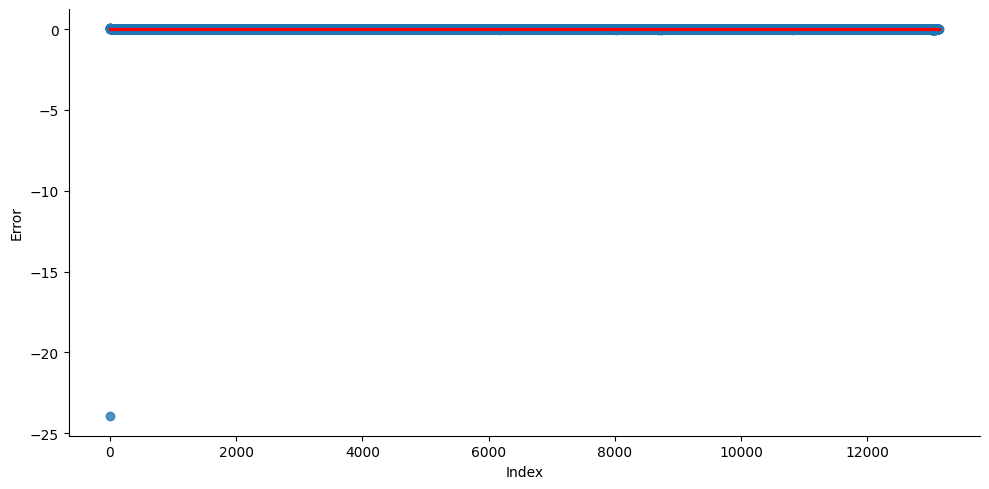

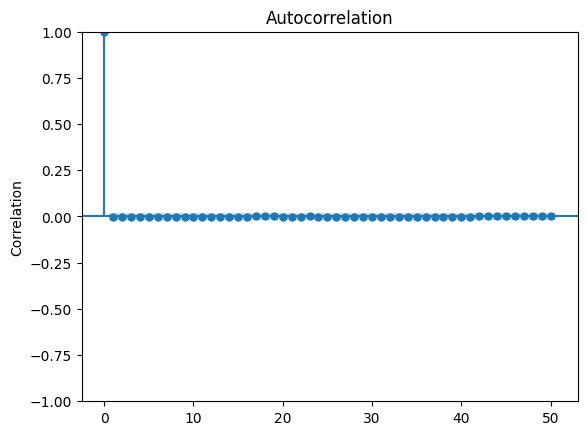

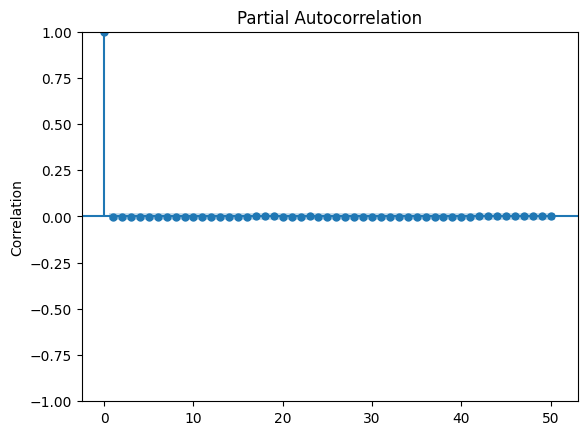

,Normality,Heteroscedasticity,Autocorr(lag10),Autocorr(lag50),Stationarity_ADF,Stationarity_KPSS
Test Statistics,0.01,0.00,0.03,0.10,-9.98,0.09
p-value,0.00,0.00,1.00,1.00,0.00,0.10
Alternative,NaN,two-sided,NaN,NaN,NaN,NaN
Used Lag,NaN,NaN,NaN,NaN,41.00,2.00
Critical Value(1%),NaN,NaN,NaN,NaN,-3.43,0.74
Critical Value(5%),NaN,NaN,NaN,NaN,-2.86,0.46
Critical Value(10%),NaN,NaN,NaN,NaN,-2.57,0.35


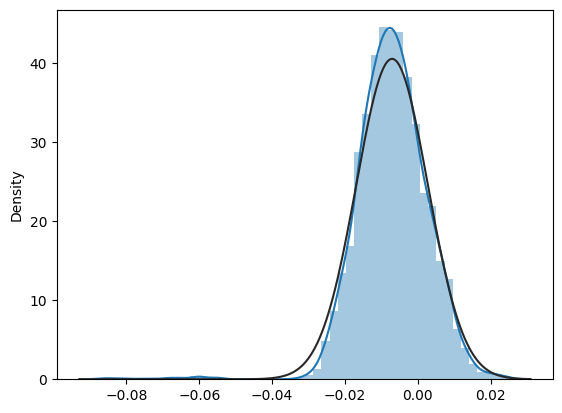

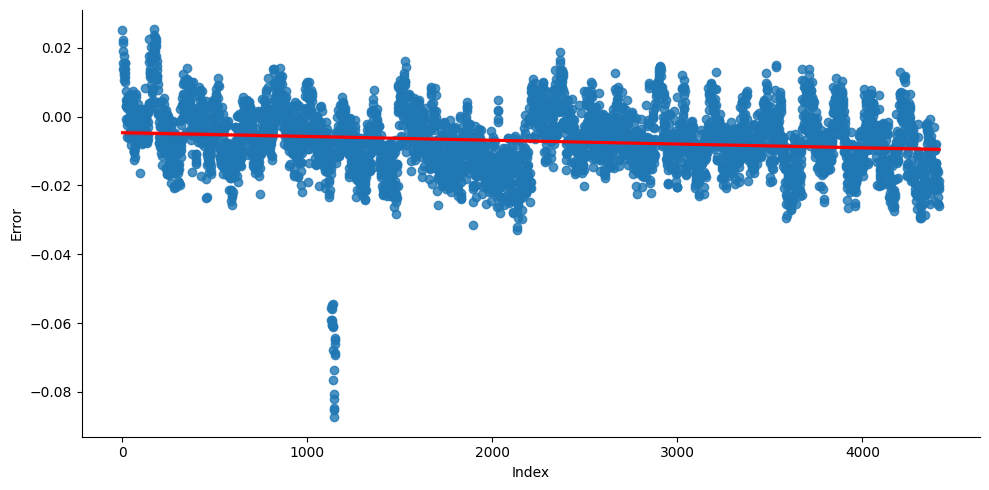

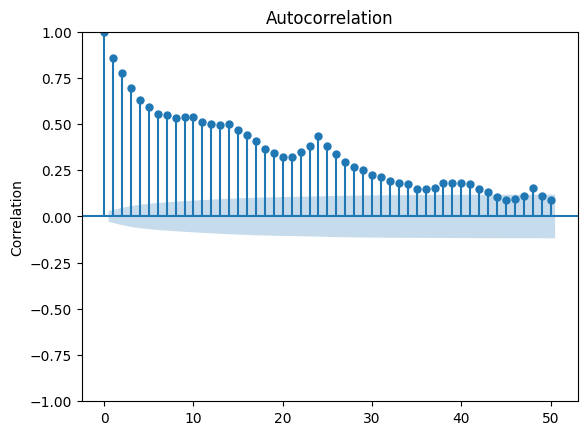

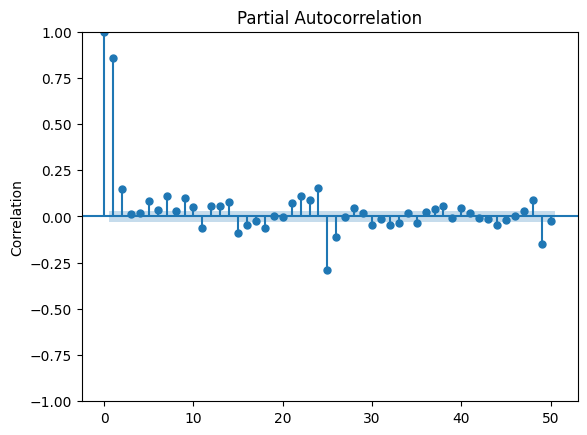

,Normality,Heteroscedasticity,Autocorr(lag10),Autocorr(lag50),Stationarity_ADF,Stationarity_KPSS
Test Statistics,0.93,0.84,"17,815.72","33,403.03",-8.08,0.51
p-value,0.00,0.00,0.00,0.00,0.00,0.04
Alternative,NaN,two-sided,NaN,NaN,NaN,NaN
Used Lag,NaN,NaN,NaN,NaN,31.00,38.00
Critical Value(1%),NaN,NaN,NaN,NaN,-3.43,0.74
Critical Value(5%),NaN,NaN,NaN,NaN,-2.86,0.46
Critical Value(10%),NaN,NaN,NaN,NaN,-2.57,0.35


In [9]:
# 데이터 로딩
location = os.path.join('.', 'data', 'Bike_Sharing_Demand_Full.csv')
df_all = pd.read_csv(location)

# 데이터 전처리
df_fe = feature_engineering(df_all)

# 데이터 분리
Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in df_fe.columns if x not in Y_colname+X_remove]
X_train, X_test, Y_train, Y_test = datasplit_ts(df_fe, Y_colname, X_colname, '2012-07-01')

# Linear Regression
model_lr = sm.OLS(Y_train, X_train).fit()
display(model_lr.summary())

Y_trpred = pd.DataFrame(model_lr.predict(X_train), columns=['Pred'])
Y_tepred = pd.DataFrame(model_lr.predict(X_test), columns=['Pred'])
plot_prediction(pd.concat([Y_train, Y_trpred], axis=1).reset_index().iloc[:,1:])
plot_prediction(pd.concat([Y_test, Y_tepred], axis=1).reset_index().iloc[:,1:])

# 분석 검증
Score_FEHalf = evaluation_reg_trte(Y_train, Y_trpred, Y_test, Y_tepred)
display(Score_FEHalf)

# 에러 분석
Resid_tr = Y_train - Y_trpred.values
Resid_tr.columns = ['Error']
Resid_te = Y_test - Y_tepred.values
Resid_te.columns = ['Error']

Error_tr = error_analysis_timeseries(X_train, Y_trpred, Resid_tr, graph_on=True)
display(Error_tr)
Error_te = error_analysis_timeseries(X_test, Y_tepred, Resid_te, graph_on=True)
display(Error_te)

In [10]:
# 검증 성능이 너무 정확하다?
Score_FEHalf

,MAE,MSE,MAPE
Train,0.01,0.04,0.00
Test,0.01,0.00,0.00


# **Preprocessing Update:** 시계열 전처리 업데이트

## 시간현실 반영(Reality)

**"미래의 시간패턴을 `미리 반영하는건 비현실적`, 이는 `과적합(Overfitting)` 유발"**

- 데이터 전처리시, `데이터 분리 후 패턴을 추출`하여 해결

<img src='./img/DataAnalysis_CycleTS3.png' width='800'>

<img src='./img/DataAnalysis_CycleTS4.png' width='800'>

In [11]:
# Test 기간의 시계열 데이터를 알 수 있을까?
# 1) 과거의 시계열 패턴이 미래에 반복될 것이라 가정할 순 있지만 알순 없음!
# 2-1) 가장 좋은 방법은 미래 시점이 도래할 때까지 기다려서 Train 업데이트 후 Test 예측!
# 2-2) 그렇지 않으면 미래 시점을 하나씩 예측 후 예측값 자체를 Train에 반영하여 Test 예측!

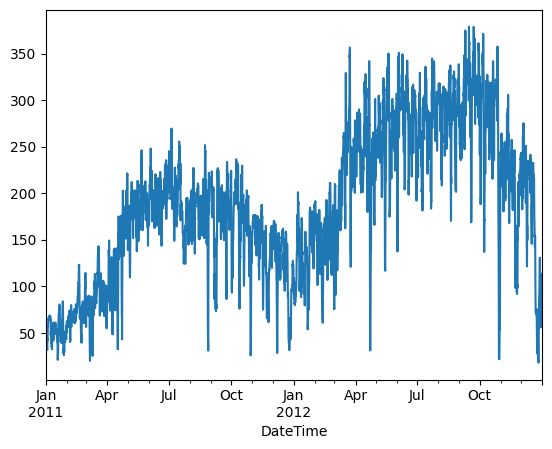

In [12]:
# 종속변수 시계열 추세 전체 확인
df_fe['count_trend'].plot()
plt.show()

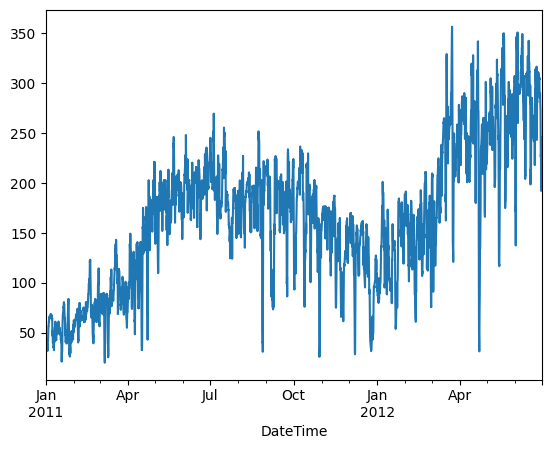

In [13]:
# 종속변수 시계열 추세 Train 확인
X_train['count_trend'].plot()
plt.show()

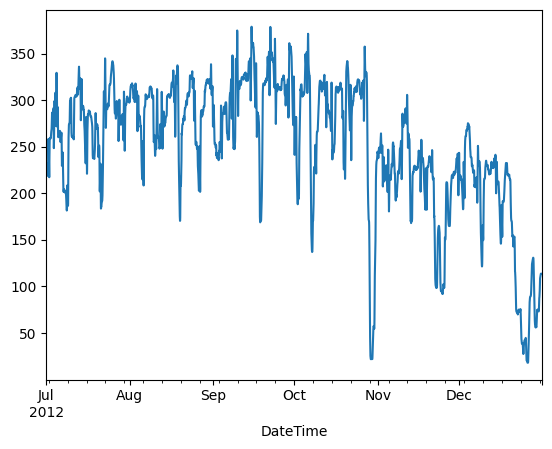

In [14]:
# 종속변수 시계열 추세 Test 확인
X_test['count_trend'].plot()
plt.show()

In [16]:
# 가정1) 2011년 7월~12월 추세가 2012년 7월~12월에도 나타날 수 있다
# 가정2) 2011년 1월~12월 추세가 2012년 1월~12월에도 나타날 수 있다 

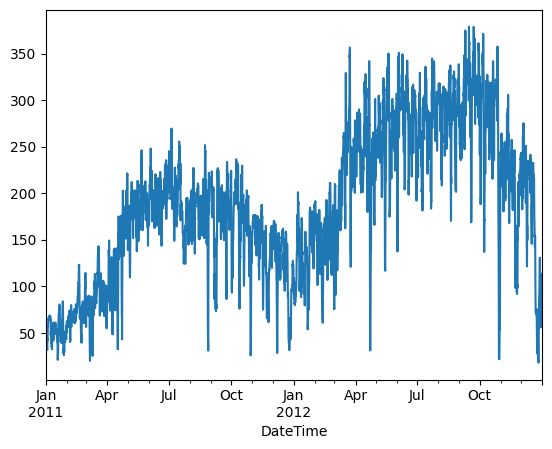

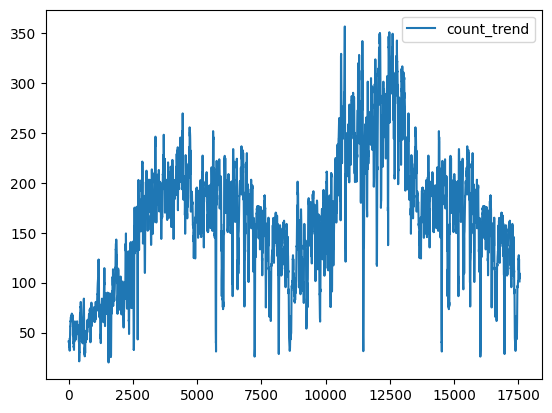

In [17]:
# 가정1의 경우로 데이터 결합시 종속변수 시계열 추세 전체 확인
df_fe['count_trend'].plot()
plt.show()
pd.concat([X_train['count_trend'],
           X_train.loc['2011-07-01':'2011-12-31', 'count_trend']],
           axis=0).reset_index().iloc[:,1:].plot()
plt.show()

In [18]:
# 가정2의 경우 추가적인 분석이 요구될 수 있음
len(df_fe.loc['2012-01-01':'2012-12-31', 'count_trend'])

8784

In [19]:
len(df_fe.loc['2011-01-01':'2011-12-31', 'count_trend'])

8760

In [23]:
# 2월 29일이 12년에는 존재하지만 11년에는 존재하지 않음
df_fe.loc['2012-02-29', 'count_trend']

DateTime
2012-02-29 00:00:00   139.69
2012-02-29 01:00:00   134.96
2012-02-29 02:00:00   130.96
2012-02-29 03:00:00   127.75
2012-02-29 04:00:00   123.67
                       ...  
2012-02-29 19:00:00    76.94
2012-02-29 20:00:00    87.96
2012-02-29 21:00:00   103.08
2012-02-29 22:00:00   110.81
2012-02-29 23:00:00   116.67
Freq: H, Name: count_trend, Length: 24, dtype: float64

In [24]:
# # 2월 29일이 12년에는 존재하지만 11년에는 존재하지 않음
# df_fe.loc['2011-02-29', 'count_trend']

In [25]:
X_test

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count_trend,count_seasonal,...,Quater_ver2,Month,Day,Hour,DayofWeek,count_lag1,count_lag2,Quater_Dummy_2,Quater_Dummy_3,Quater_Dummy_4
DateTime,,,,,,,,,,,,,,,,,,,,,
2012-07-01 00:00:00,3,0,0,1,31.16,36.37,66,0.00,230.42,-134.25,...,7,7,1,0,6,152.00,172.00,0,1,0
2012-07-01 01:00:00,3,0,0,1,30.34,34.85,70,9.00,229.46,-154.75,...,7,7,1,1,6,149.00,152.00,0,1,0
2012-07-01 02:00:00,3,0,0,1,29.52,34.85,74,6.00,230.02,-165.27,...,7,7,1,2,6,93.00,149.00,0,1,0
2012-07-01 03:00:00,3,0,0,1,29.52,35.60,84,9.00,229.52,-176.48,...,7,7,1,3,6,90.00,93.00,0,1,0
2012-07-01 04:00:00,3,0,0,1,28.70,33.34,79,13.00,227.04,-181.67,...,7,7,1,4,6,33.00,90.00,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-31 19:00:00,1,0,1,2,10.66,12.88,60,11.00,113.71,122.70,...,8,12,31,19,0,122.00,164.00,0,0,1
2012-12-31 20:00:00,1,0,1,2,10.66,12.88,60,11.00,113.71,37.48,...,8,12,31,20,0,119.00,122.00,0,0,1
2012-12-31 21:00:00,1,0,1,1,10.66,12.88,60,11.00,113.71,-16.10,...,8,12,31,21,0,89.00,119.00,0,0,1


In [27]:
# 수동으로 반영 필요
X_train.loc['2012-01-01':'2012-02-28', 'count_trend'] = X_train.loc['2011-01-01':'2011-02-28', 'count_trend'].values
X_train.loc['2012-03-01':'2012-06-30', 'count_trend'] = X_train.loc['2011-03-01':'2011-06-30', 'count_trend'].values
X_test.loc['2012-07-01':'2012-12-31', 'count_trend'] = X_train.loc['2011-07-01':'2011-12-31', 'count_trend'].values

In [28]:
# 2012-02-29??
X_train.loc['2011-02-28 23:00:00':'2011-03-01', 'count_trend']

DateTime
2011-02-28 23:00:00   56.48
2011-03-01 00:00:00   56.87
2011-03-01 01:00:00   58.87
2011-03-01 02:00:00   60.96
2011-03-01 03:00:00   62.69
                       ... 
2011-03-01 19:00:00   77.15
2011-03-01 20:00:00   78.08
2011-03-01 21:00:00   79.46
2011-03-01 22:00:00   80.12
2011-03-01 23:00:00   80.65
Freq: H, Name: count_trend, Length: 25, dtype: float64

In [29]:
# 단순하기 2월 28일 마지막 값과 3월 1일 첫번째 간격을 24등분하여 2월 29일 값을 생성
# 일반적으로 내부 값을 이어서 채운다고 하여 interpolation 방법이라고 하며,
# 정교하게는 2월 28일까지의 데이터로 2월 29일 데이터를 별도 예측하여 반영
step = (X_train.loc['2011-03-01 00:00:00', 'count_trend'] - X_train.loc['2011-02-28 23:00:00', 'count_trend'])/25
step_value = np.arange(X_train.loc['2011-02-28 23:00:00', 'count_trend']+step,
                       X_train.loc['2011-03-01 00:00:00', 'count_trend'], step)
step_value = step_value[:24]
X_train.loc['2012-02-29', 'count_trend'] = step_value

In [30]:
# 12년 2월 29일 생성 데이터 확인
X_train.loc['2012-02-28 22:00:00':'2012-03-1 02:00:00', 'count_trend']

DateTime
2012-02-28 22:00:00   57.62
2012-02-28 23:00:00   56.48
2012-02-29 00:00:00   56.49
2012-02-29 01:00:00   56.51
2012-02-29 02:00:00   56.53
                       ... 
2012-02-29 22:00:00   56.84
2012-02-29 23:00:00   56.86
2012-03-01 00:00:00   56.87
2012-03-01 01:00:00   58.87
2012-03-01 02:00:00   60.96
Freq: H, Name: count_trend, Length: 29, dtype: float64

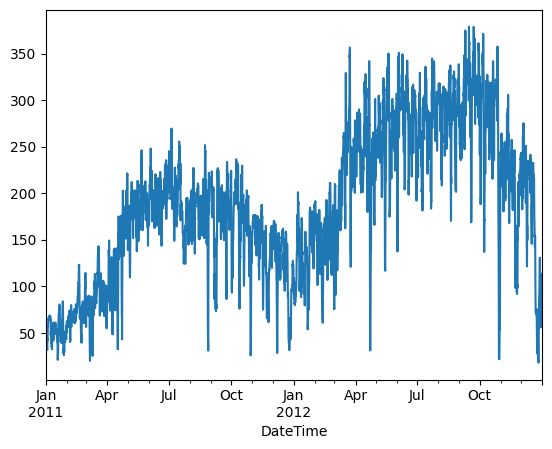

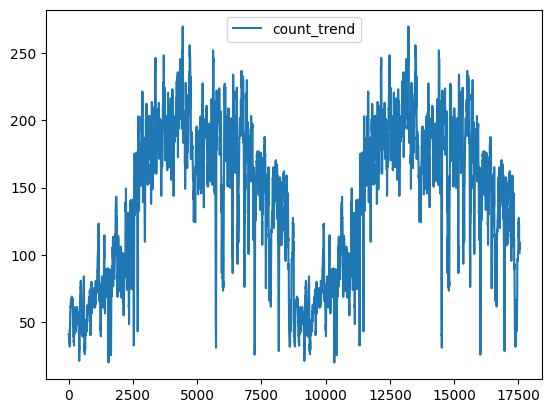

In [31]:
# 가정2의 경우로 데이터 결합시 종속변수 시계열 추세 전체 확인
df_fe['count_trend'].plot()
plt.show()
pd.concat([X_train['count_trend'],
           X_test['count_trend']],
           axis=0).reset_index().iloc[:,1:].plot()
plt.show()

In [34]:
# 2011년 데이터 시계열 패턴으로 2012년 데이터로 가정
def feature_engineering_year_duplicated(X_train, X_test, target):
    X_train_R, X_test_R = X_train.copy(), X_test.copy()
    for col in target:
        X_train_R.loc['2012-01-01':'2012-02-28', col] = X_train_R.loc['2011-01-01':'2011-02-28', col].values
        X_train_R.loc['2012-03-01':'2012-06-30', col] = X_train_R.loc['2011-03-01':'2011-06-30', col].values
        X_test_R.loc['2012-07-01':'2012-12-31', col] = X_train_R.loc['2011-07-01':'2011-12-31', col].values

        step = (X_train_R.loc['2011-03-01 00:00:00', col] - X_train_R.loc['2011-02-28 23:00:00', col])/25
        step_value = np.arange(X_train_R.loc['2011-02-28 23:00:00', col]+step,
                               X_train_R.loc['2011-03-01 00:00:00', col], step)
        step_value = step_value[:24]
        X_train_R.loc['2012-02-29', col] = step_value
    return X_train_R, X_test_R

target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
X_train_R, X_test_R = feature_engineering_year_duplicated(X_train, X_test, target)

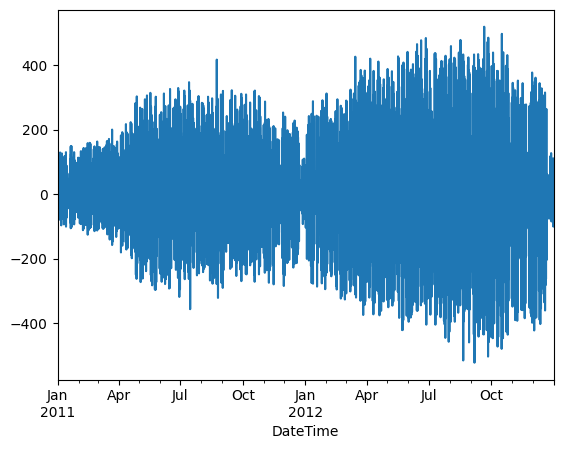

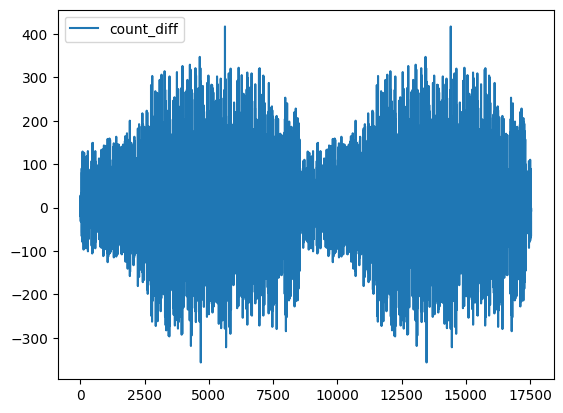

In [35]:
# 가정 2의 경우로 데이터 결합시 종속변수 시계열 차분 전체 확인
df_fe['count_diff'].plot()
plt.show()
pd.concat([X_train_R['count_diff'],
           X_test_R['count_diff']],
           axis=0).reset_index().iloc[:,1:].plot()
plt.show()

In [36]:
# count_lag1, count_lag2 지연값은 어떻게 처리?
# X_test의 일부 데이터응 X_train에서 넘어온 값
# 가정하여 사용할 순 있지만 분할 후 전처리 방식은 아님!
X_test_R.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count_trend,count_seasonal,...,Quater_ver2,Month,Day,Hour,DayofWeek,count_lag1,count_lag2,Quater_Dummy_2,Quater_Dummy_3,Quater_Dummy_4
DateTime,,,,,,,,,,,,,,,,,,,,,
2012-07-01 00:00:00,3,0,0,1,31.16,36.37,66,0.00,228.46,-134.25,...,7,7,1,0,6,152.00,172.00,0,1,0
2012-07-01 01:00:00,3,0,0,1,30.34,34.85,70,9.00,230.33,-154.75,...,7,7,1,1,6,149.00,152.00,0,1,0
2012-07-01 02:00:00,3,0,0,1,29.52,34.85,74,6.00,234.50,-165.27,...,7,7,1,2,6,93.00,149.00,0,1,0
2012-07-01 03:00:00,3,0,0,1,29.52,35.60,84,9.00,240.35,-176.48,...,7,7,1,3,6,90.00,93.00,0,1,0
2012-07-01 04:00:00,3,0,0,1,28.70,33.34,79,13.00,245.46,-181.67,...,7,7,1,4,6,33.00,90.00,0,1,0


In [37]:
# 종속변수에서 지연처리 후 NaN은 Train이 아닌 Test 값에서 채워야 함
Y_test.shift(2)

,count
DateTime,
2012-07-01 00:00:00,NaN
2012-07-01 01:00:00,NaN
2012-07-01 02:00:00,149.00
2012-07-01 03:00:00,93.00
2012-07-01 04:00:00,90.00
...,...
2012-12-31 19:00:00,164.00
2012-12-31 20:00:00,122.00
2012-12-31 21:00:00,119.00


In [38]:
# 종속변수에서 지연처리 후 NaN은 Train이 아닌 Test 값에서 채워야 함
X_test_R['count_lag1'] = Y_test.shift(1).values
X_test_R['count_lag1'].fillna(method='bfill', inplace=True)
X_test_R['count_lag2'] = Y_test.shift(2).values
X_test_R['count_lag2'].fillna(method='bfill', inplace=True)
X_test_R['count_lag2']

DateTime
2012-07-01 00:00:00   149.00
2012-07-01 01:00:00   149.00
2012-07-01 02:00:00   149.00
2012-07-01 03:00:00    93.00
2012-07-01 04:00:00    90.00
                       ...  
2012-12-31 19:00:00   164.00
2012-12-31 20:00:00   122.00
2012-12-31 21:00:00   119.00
2012-12-31 22:00:00    89.00
2012-12-31 23:00:00    90.00
Freq: H, Name: count_lag2, Length: 4416, dtype: float64

In [39]:
# 종속변수에서 지연처리 후 NaN은 Train이 아닌 Test 값에서 채움
def feature_engineering_lag_modified(Y_test, X_test, target):
    X_test_R = X_test.copy()
    for col in target:
        X_test_R[col] = Y_test.shift(1).values
        X_test_R[col].fillna(method='bfill', inplace=True)
        X_test_R[col] = Y_test.shift(2).values
        X_test_R[col].fillna(method='bfill', inplace=True)
    
    return X_test_R

target = ['count_lag1', 'count_lag2']
X_test_R = feature_engineering_lag_modified(Y_test, X_test, target)

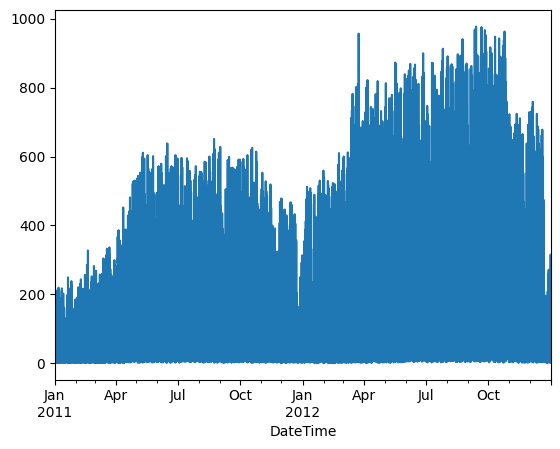

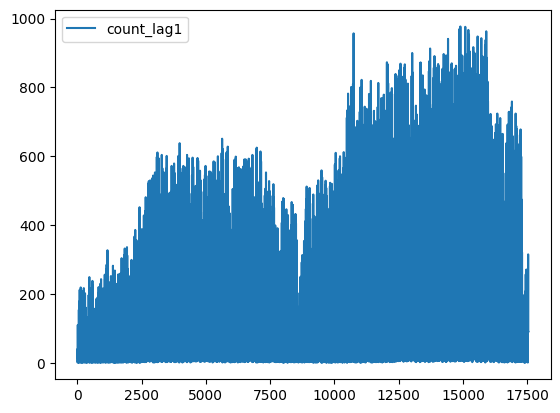

In [40]:
# 가정 2의 경우로 데이터 결합시 종속변수 시계열 차분 전체 확인
df_fe['count_lag1'].plot()
plt.show()
pd.concat([X_train_R['count_lag1'],
           X_test_R['count_lag1']],
           axis=0).reset_index().iloc[:,1:].plot()
plt.show()

### Code Summary

In [45]:
# 2011년 데이터 시계열 패턴으로 2012년 데이터로 가정
def feature_engineering_year_duplicated(X_train, X_test, target):
    X_train_R, X_test_R = X_train.copy(), X_test.copy()
    for col in target:
        X_train_R.loc['2012-01-01':'2012-02-28', col] = X_train_R.loc['2011-01-01':'2011-02-28', col].values
        X_train_R.loc['2012-03-01':'2012-06-30', col] = X_train_R.loc['2011-03-01':'2011-06-30', col].values
        X_test_R.loc['2012-07-01':'2012-12-31', col] = X_train_R.loc['2011-07-01':'2011-12-31', col].values
        
        step = (X_train_R.loc['2011-03-01 00:00:00', col] - X_train_R.loc['2011-02-28 23:00:00', col])/25
        step_value = np.arange(X_train_R.loc['2011-02-28 23:00:00', col]+step, 
                               X_train_R.loc['2011-03-01 00:00:00', col], step)
        step_value = step_value[:24]
        X_train_R.loc['2012-02-29', col] = step_value

    return X_train_R, X_test_R


# 종속변수에서 지연처리 후 NaN은 Train이 아닌 Test 값에서 채움
def feature_engineering_lag_modified(Y_test, X_test, target):
    X_test_R = X_test.copy()
    for col in target:
        X_test_R[col] = Y_test.shift(1).values
        X_test_R[col].fillna(method='bfill', inplace=True)
        X_test_R[col] = Y_test.shift(2).values
        X_test_R[col].fillna(method='bfill', inplace=True)
        
    return X_test_R

Train_size: (13128, 28) Test_size: (4416, 28)
X_train: (13128, 24) Y_train: (13128, 1)
X_test: (4416, 24) Y_test: (4416, 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     5658.
Date:                Sat, 29 Apr 2023   Prob (F-statistic):               0.00
Time:                        14:53:11   Log-Likelihood:                -69618.
No. Observations:               13128   AIC:                         1.393e+05
Df Residuals:                   13104   BIC:                         1.395e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
season             2.7535      0.952      2.893      0.004       0.888       4.619
holiday            0.6180      3.170      0.195      0.845      -5.595       6.831
workingday         2.1960      1.544      1.423      0.155      -0.830       5.222
weather           -5.8817      0.780     -7.544      0.000      -7.410      -4.353
temp               0.5622      0.490      1.146      0.252      -0.399       1.523
atemp              0.4042      0.427      0.946      0.344      -0.433       1.242
humidity          -0.0706      0.028     -2.501      0.012      -0.126      -0.015
windspeed         -0.1216      0.057     -2.117      0.034      -0.234      -0.009
count_trend        0.0718      0.024      3.007      0.003       0.025       0.119
count_seasonal     0.1948      0.006     34.600      0.000       0.184       0.206
count_Day          0.1011      0.024      4.190      0.000       0.054       0.148
count_Week        -0.0801      0.026     -3.078      0.002      -0.131      -0.029
count_diff         0.7146      0.007     97.737      0.000       0.700       0.729
Year               0.0004      0.002      0.188      0.851      -0.003       0.004
Quater_ver2        5.6849      0.284     19.988      0.000       5.127       6.242
Month              1.1013      0.566      1.945      0.052      -0.009       2.211
Day               -0.0335      0.049     -0.681      0.496      -0.130       0.063
Hour               0.1185      0.083      1.420      0.156      -0.045       0.282
DayofWeek          0.3611      0.354      1.021      0.307      -0.332       1.055
count_lag1         0.9285      0.006    149.851      0.000       0.916       0.941
count_lag2        -0.1938      0.006    -33.734      0.000      -0.205      -0.183
Quater_Dummy_2    -7.2671      2.213     -3.284      0.001     -11.605      -2.929
Quater_Dummy_3   -21.5188      3.728     -5.773      0.000     -28.825     -14.212
Quater_Dummy_4   -26.7509      5.511     -4.854      0.000     -37.554     -15.948
==============================================================================
Omnibus:                     3715.248   Durbin-Watson:                   1.582
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           115549.958
Skew:                           0.728   Prob(JB):                         0.00
Kurtosis:                      17.461   Cond. No.                     3.22e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.22e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

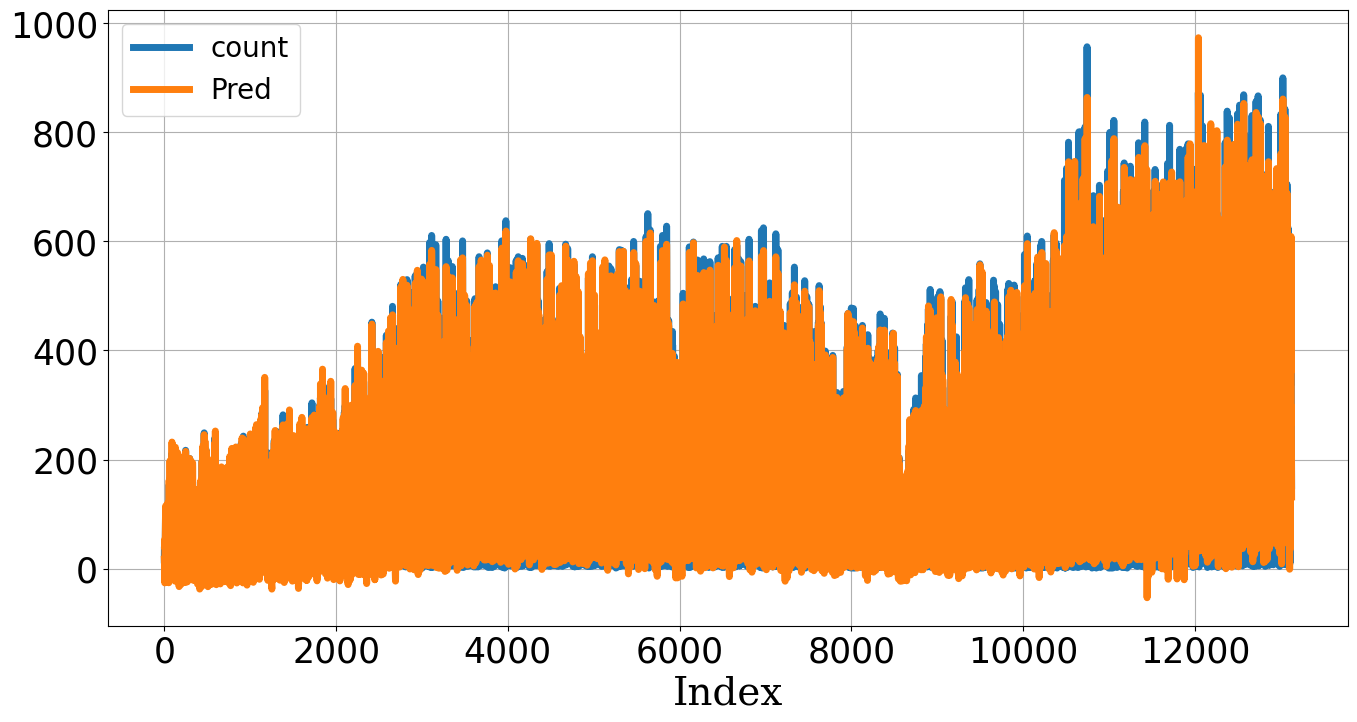

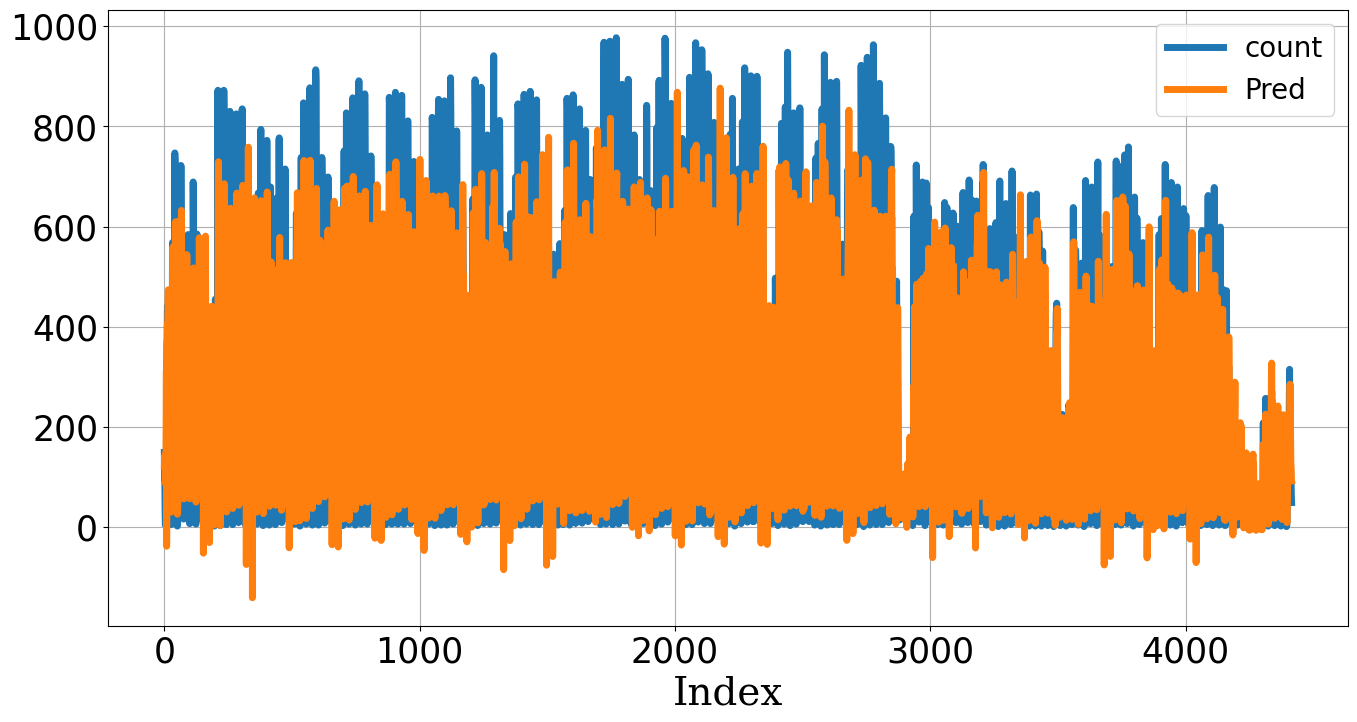

,MAE,MSE,MAPE
Train,27.79,"2,364.05",0.82
Test,113.99,"26,316.17",1.34


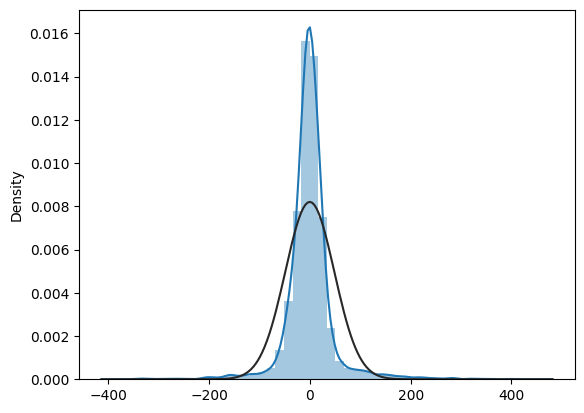

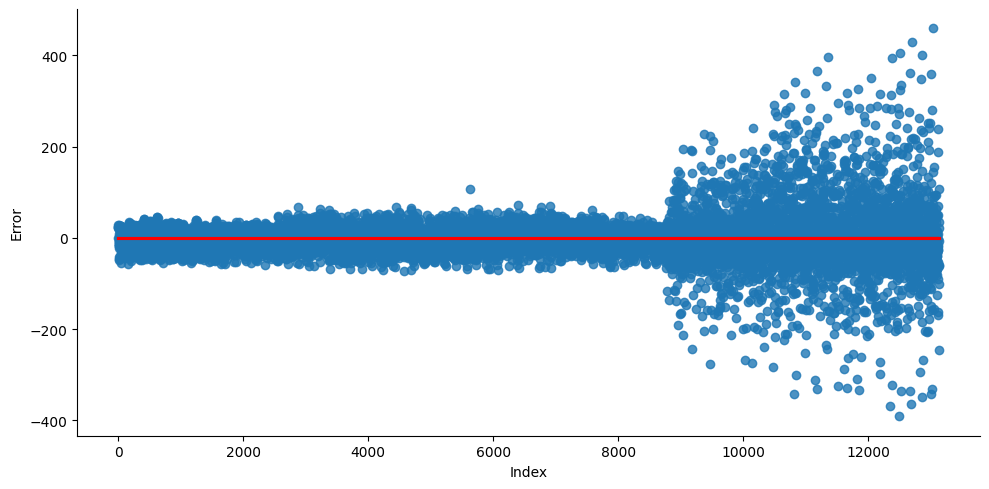

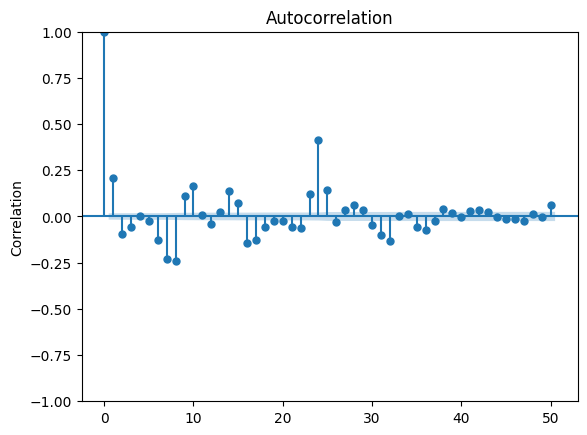

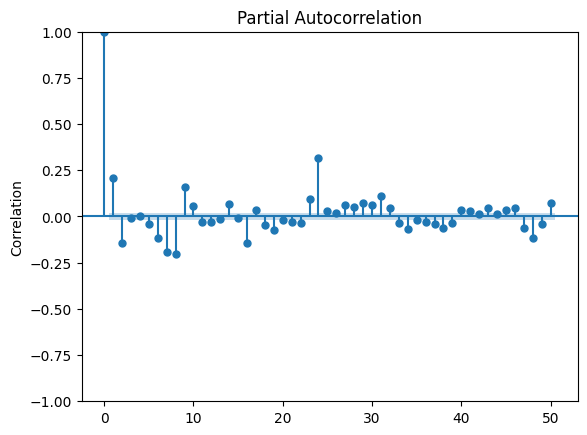

,Normality,Heteroscedasticity,Autocorr(lag10),Autocorr(lag50),Stationarity_ADF,Stationarity_KPSS
Test Statistics,0.78,"16,218.77","2,927.28","7,390.92",-13.45,0.06
p-value,0.00,0.00,0.00,0.00,0.00,0.10
Alternative,NaN,two-sided,NaN,NaN,NaN,NaN
Used Lag,NaN,NaN,NaN,NaN,41.00,460.00
Critical Value(1%),NaN,NaN,NaN,NaN,-3.43,0.74
Critical Value(5%),NaN,NaN,NaN,NaN,-2.86,0.46
Critical Value(10%),NaN,NaN,NaN,NaN,-2.57,0.35


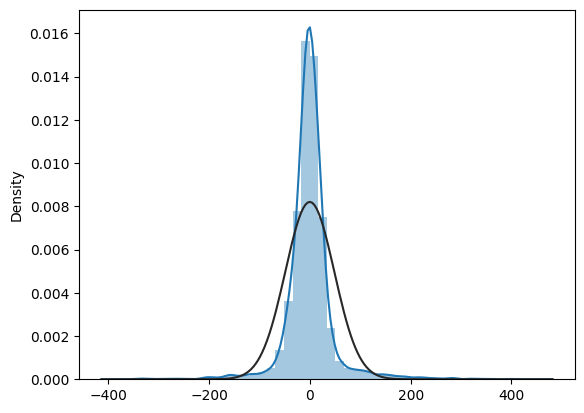

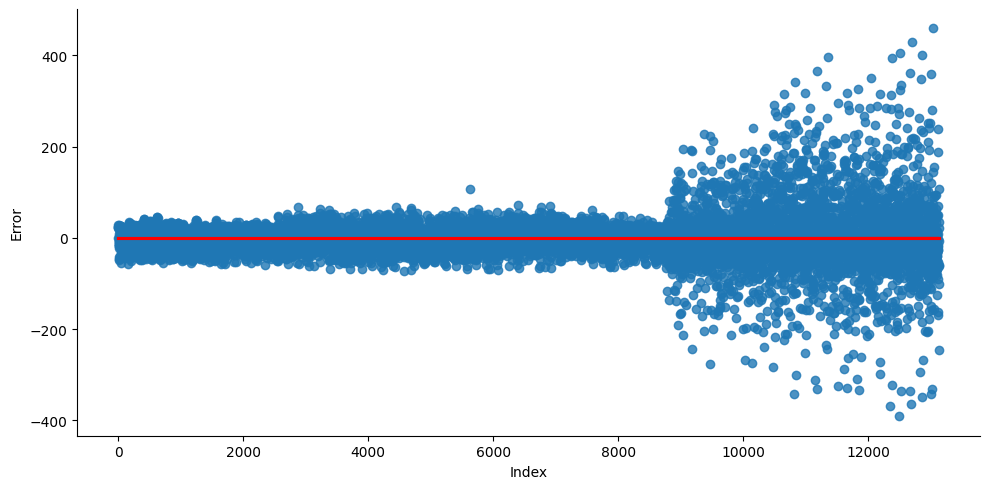

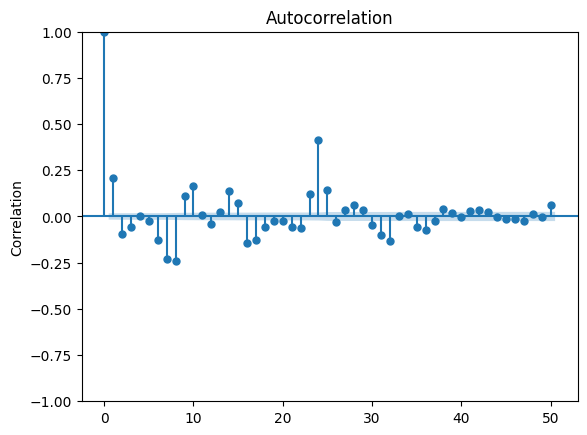

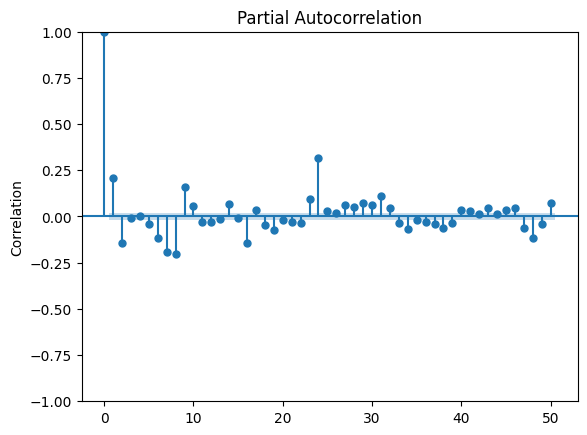

,Normality,Heteroscedasticity,Autocorr(lag10),Autocorr(lag50),Stationarity_ADF,Stationarity_KPSS
Test Statistics,0.78,"16,218.77","2,927.28","7,390.92",-13.45,0.06
p-value,0.00,0.00,0.00,0.00,0.00,0.10
Alternative,NaN,two-sided,NaN,NaN,NaN,NaN
Used Lag,NaN,NaN,NaN,NaN,41.00,460.00
Critical Value(1%),NaN,NaN,NaN,NaN,-3.43,0.74
Critical Value(5%),NaN,NaN,NaN,NaN,-2.86,0.46
Critical Value(10%),NaN,NaN,NaN,NaN,-2.57,0.35


In [46]:
# 데이터 로딩
location = os.path.join('.', 'data', 'Bike_Sharing_Demand_Full.csv')
df_all = pd.read_csv(location)

# 데이터 전처리
df_fe = feature_engineering(df_all)

# 데이터 분리
Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in df_fe.columns if x not in Y_colname+X_remove]
X_train, X_test, Y_train, Y_test = datasplit_ts(df_fe, Y_colname, X_colname, '2012-07-01')

# 데이터 전처리(현실성)
### Reality ###
target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
X_train_R, X_test_R = feature_engineering_year_duplicated(X_train, X_test, target)
target = ['count_lag1', 'count_lag2']
X_test_R = feature_engineering_lag_modified(Y_test, X_test_R, target)
###############

# Linear Regression
model_lr_R = sm.OLS(Y_train, X_train_R).fit()
display(model_lr_R.summary())

Y_trpred_R = pd.DataFrame(model_lr_R.predict(X_train_R), columns=['Pred'])
Y_tepred_R = pd.DataFrame(model_lr_R.predict(X_test_R), columns=['Pred'])
plot_prediction(pd.concat([Y_train, Y_trpred_R], axis=1).reset_index().iloc[:,1:])
plot_prediction(pd.concat([Y_test, Y_tepred_R], axis=1).reset_index().iloc[:,1:])

# 분석 검증
Score_R = evaluation_reg_trte(Y_train, Y_trpred_R, Y_test, Y_tepred_R)
display(Score_R)

# 에러 분석
Resid_tr = Y_train - Y_trpred_R.values
Resid_tr.columns = ['Error']
Resid_te = Y_test - Y_tepred_R.values
Resid_te.columns = ['Error']

Error_tr_R = error_analysis_timeseries(X_train, Y_trpred, Resid_tr, graph_on=True)
display(Error_tr_R)
Error_te_R = error_analysis_timeseries(X_train, Y_trpred, Resid_tr, graph_on=True)
display(Error_te_R)

## 스케일 조정(Scaling)

- **목적:** 변수들의 `크기를 일정하게 맞추어` `크기` 때문에 `영향`이 높은 현상을 회피

    - **수학적:** 독립 변수의 공분산 `행렬 조건수(Condition Number)를 감소`시켜 최적화 안정성 및 수렴 속도 향상 

    - **컴퓨터적:** PC 메모리를 고려하여 `오버플로우(Overflow)나 언더플로우(Underflow)를 줄여줌` 


#### 1) Standard Scaler : $\dfrac{X_{it} - E(X_i)}{SD(X_i)}$

- 기본 스케일로 평균을 제외하고 표준편차를 나누어 변환  

- 각 변수(Feature)가 `정규분포를 따른다는 가정`이기에 정규분포가 아닐 시 최선이 아닐 수 있음 

```python
sklearn.preprocessing.StandardScaler().fit()
sklearn.preprocessing.StandardScaler().transform()
sklearn.preprocessing.StandardScaler().fit_transform()
```

<img src='./img/Scaling_StandardScaler.png' width='500'>

#### 2) Min-Max Scaler : $\dfrac{X_{it} - min(X_i)}{max(X_i) - min(X_i)}$

- 가장 많이 활용되는 방식으로 최소\~최대 값이 `0~1` 또는 `-1~1` 사이의 값으로 변환  

- 각 변수(Feature)가 `정규분포가 아니거나 표준편차가 매우 작을 때` 효과적

```python
sklearn.preprocessing.MinMaxScaler().fit()
sklearn.preprocessing.MinMaxScaler().transform()
sklearn.preprocessing.MinMaxScaler().fit_transform()
```

<img src='./img/Scaling_MinMaxScaler.png' width='500'>

#### 3) Robust Scaler : $\dfrac{X_{it} - Q_1(X_i)}{Q_3(X_i) - Q_1(X_i)}$

- 최소-최대 스케일러와 유사하지만 `최소/최대 대신`에 IQR(Interquartile Range) 중 `25%값/75%값`을 사용하여 변환  

- 이상치(Outlier)에 영향을 최소화하였기에 `이상치가 있는 데이터에 효과적`이고 `적은 데이터에도 효과적`인 편 

```python
sklearn.preprocessing.RobustScaler().fit()
sklearn.preprocessing.RobustScaler().transform()
sklearn.preprocessing.RobustScaler().fit_transform()
```

<img src='./img/Scaling_RobustScaler.png' width='500'>

#### 4) Normalizer : $\dfrac{X_{it}}{\sqrt{X_{i}^2 + X_{j}^2 + ... + X_{k}^2}}$

- 각 변수(Feature)를 전체 `n`개 `모든 변수들의 크기들로 나누어`서 변환(by Cartesian Coordinates)  

- 각 변수들의 값은 `원점으로부터 반지름 1만큼 떨어진 범위 내`로 변환

```python
sklearn.preprocessing.Normalizer().fit()
sklearn.preprocessing.Normalizer().transform()
sklearn.preprocessing.Normalizer().fit_transform()
```

<img src='./img/Scaling_Normalizer.png' width='500'>

In [47]:
# X_train 데이터의 수치 크기 범위를 확인해보기
X_train_R

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count_trend,count_seasonal,...,Quater_ver2,Month,Day,Hour,DayofWeek,count_lag1,count_lag2,Quater_Dummy_2,Quater_Dummy_3,Quater_Dummy_4
DateTime,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.39,81,0.00,41.06,-134.25,...,1,1,1,0,5,16.00,16.00,0,0,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.63,80,0.00,41.06,-154.75,...,1,1,1,1,5,16.00,16.00,0,0,0
2011-01-01 02:00:00,1,0,0,1,9.02,13.63,80,0.00,41.06,-165.27,...,1,1,1,2,5,40.00,16.00,0,0,0
2011-01-01 03:00:00,1,0,0,1,9.84,14.39,75,0.00,41.06,-176.48,...,1,1,1,3,5,32.00,40.00,0,0,0
2011-01-01 04:00:00,1,0,0,1,9.84,14.39,75,0.00,41.06,-181.67,...,1,1,1,4,5,13.00,32.00,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-06-30 19:00:00,3,0,0,1,34.44,37.88,44,17.00,228.60,122.70,...,6,6,30,19,5,339.00,362.00,1,0,0
2012-06-30 20:00:00,3,0,0,1,33.62,38.63,52,11.00,225.69,37.48,...,6,6,30,20,5,374.00,339.00,1,0,0
2012-06-30 21:00:00,3,0,0,1,33.62,38.63,52,11.00,224.37,-16.10,...,6,6,30,21,5,292.00,374.00,1,0,0


In [48]:
# sklearn 모듈내 preprocessing 함수 호출하기
# preprocessing 함수 내 MinMaxScaler를 호출하여 변수에 저장하기
# train 데이터에 scaling 적용을 위해 파라미터 추정하기
# 추정된 파라미터를 train 데이터에 적용하여 모든 변수들의 크기를 맞추기
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler()
scaler_fit = scaler.fit(X_train_R)
scaler_fit.transform(X_train_R)

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.66666667, 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.66666667, 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.66666667, 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ]])

In [49]:
# 출력된 X_train 데이터를 DataFrame 형식으로 출력하기
pd.DataFrame(scaler_fit.transform(X_train_R))

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.00,0.00,0.00,0.00,0.23,0.29,0.81,0.00,0.08,0.10,...,0.00,0.00,0.00,0.00,0.83,0.02,0.02,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.21,0.27,0.80,0.00,0.08,0.06,...,0.00,0.00,0.00,0.04,0.83,0.02,0.02,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.21,0.27,0.80,0.00,0.08,0.04,...,0.00,0.00,0.00,0.09,0.83,0.04,0.02,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.23,0.29,0.75,0.00,0.08,0.01,...,0.00,0.00,0.00,0.13,0.83,0.03,0.04,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.23,0.29,0.75,0.00,0.08,0.00,...,0.00,0.00,0.00,0.17,0.83,0.01,0.03,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13123,0.67,0.00,0.00,0.00,0.85,0.76,0.44,0.30,0.84,0.67,...,1.00,0.45,0.97,0.83,0.83,0.35,0.38,1.00,0.00,0.00
13124,0.67,0.00,0.00,0.00,0.83,0.77,0.52,0.19,0.82,0.48,...,1.00,0.45,0.97,0.87,0.83,0.39,0.35,1.00,0.00,0.00
13125,0.67,0.00,0.00,0.00,0.83,0.77,0.52,0.19,0.82,0.36,...,1.00,0.45,0.97,0.91,0.83,0.30,0.39,1.00,0.00,0.00
13126,0.67,0.00,0.00,0.00,0.79,0.74,0.62,0.19,0.82,0.27,...,1.00,0.45,0.97,0.96,0.83,0.22,0.30,1.00,0.00,0.00


In [50]:
# 출력된 X_train 데이터를 DataFrame 형식으로 출력하는데 column 이름을 X_train 값으로 사용하기
pd.DataFrame(scaler_fit.transform(X_train_R), columns=X_train_R.columns)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count_trend,count_seasonal,...,Quater_ver2,Month,Day,Hour,DayofWeek,count_lag1,count_lag2,Quater_Dummy_2,Quater_Dummy_3,Quater_Dummy_4
0,0.00,0.00,0.00,0.00,0.23,0.29,0.81,0.00,0.08,0.10,...,0.00,0.00,0.00,0.00,0.83,0.02,0.02,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.21,0.27,0.80,0.00,0.08,0.06,...,0.00,0.00,0.00,0.04,0.83,0.02,0.02,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.21,0.27,0.80,0.00,0.08,0.04,...,0.00,0.00,0.00,0.09,0.83,0.04,0.02,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.23,0.29,0.75,0.00,0.08,0.01,...,0.00,0.00,0.00,0.13,0.83,0.03,0.04,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.23,0.29,0.75,0.00,0.08,0.00,...,0.00,0.00,0.00,0.17,0.83,0.01,0.03,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13123,0.67,0.00,0.00,0.00,0.85,0.76,0.44,0.30,0.84,0.67,...,1.00,0.45,0.97,0.83,0.83,0.35,0.38,1.00,0.00,0.00
13124,0.67,0.00,0.00,0.00,0.83,0.77,0.52,0.19,0.82,0.48,...,1.00,0.45,0.97,0.87,0.83,0.39,0.35,1.00,0.00,0.00
13125,0.67,0.00,0.00,0.00,0.83,0.77,0.52,0.19,0.82,0.36,...,1.00,0.45,0.97,0.91,0.83,0.30,0.39,1.00,0.00,0.00
13126,0.67,0.00,0.00,0.00,0.79,0.74,0.62,0.19,0.82,0.27,...,1.00,0.45,0.97,0.96,0.83,0.22,0.30,1.00,0.00,0.00


In [51]:
# 전처리 코드 정리 및 결과 생성
scaler = preprocessing.MinMaxScaler()
scaler_fit = scaler.fit(X_train_R)
X_train_RS = pd.DataFrame(scaler_fit.transform(X_train_R), 
                         index=X_train_R.index, columns=X_train_R.columns)
X_test_RS = pd.DataFrame(scaler_fit.transform(X_test_R),
                         index=X_test_R.index, columns=X_test_R.columns)

In [52]:
# 변환된 최종 X_train, X_test 출력하기
display(X_train_RS, X_test_RS)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count_trend,count_seasonal,...,Quater_ver2,Month,Day,Hour,DayofWeek,count_lag1,count_lag2,Quater_Dummy_2,Quater_Dummy_3,Quater_Dummy_4
DateTime,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,0.00,0.00,0.00,0.00,0.23,0.29,0.81,0.00,0.08,0.10,...,0.00,0.00,0.00,0.00,0.83,0.02,0.02,0.00,0.00,0.00
2011-01-01 01:00:00,0.00,0.00,0.00,0.00,0.21,0.27,0.80,0.00,0.08,0.06,...,0.00,0.00,0.00,0.04,0.83,0.02,0.02,0.00,0.00,0.00
2011-01-01 02:00:00,0.00,0.00,0.00,0.00,0.21,0.27,0.80,0.00,0.08,0.04,...,0.00,0.00,0.00,0.09,0.83,0.04,0.02,0.00,0.00,0.00
2011-01-01 03:00:00,0.00,0.00,0.00,0.00,0.23,0.29,0.75,0.00,0.08,0.01,...,0.00,0.00,0.00,0.13,0.83,0.03,0.04,0.00,0.00,0.00
2011-01-01 04:00:00,0.00,0.00,0.00,0.00,0.23,0.29,0.75,0.00,0.08,0.00,...,0.00,0.00,0.00,0.17,0.83,0.01,0.03,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-06-30 19:00:00,0.67,0.00,0.00,0.00,0.85,0.76,0.44,0.30,0.84,0.67,...,1.00,0.45,0.97,0.83,0.83,0.35,0.38,1.00,0.00,0.00
2012-06-30 20:00:00,0.67,0.00,0.00,0.00,0.83,0.77,0.52,0.19,0.82,0.48,...,1.00,0.45,0.97,0.87,0.83,0.39,0.35,1.00,0.00,0.00
2012-06-30 21:00:00,0.67,0.00,0.00,0.00,0.83,0.77,0.52,0.19,0.82,0.36,...,1.00,0.45,0.97,0.91,0.83,0.30,0.39,1.00,0.00,0.00


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count_trend,count_seasonal,...,Quater_ver2,Month,Day,Hour,DayofWeek,count_lag1,count_lag2,Quater_Dummy_2,Quater_Dummy_3,Quater_Dummy_4
DateTime,,,,,,,,,,,,,,,,,,,,,
2012-07-01 00:00:00,0.67,0.00,0.00,0.00,0.77,0.73,0.66,0.00,0.84,0.10,...,1.20,0.55,0.00,0.00,1.00,0.15,0.15,0.00,1.00,0.00
2012-07-01 01:00:00,0.67,0.00,0.00,0.00,0.75,0.70,0.70,0.16,0.84,0.06,...,1.20,0.55,0.00,0.04,1.00,0.15,0.15,0.00,1.00,0.00
2012-07-01 02:00:00,0.67,0.00,0.00,0.00,0.73,0.70,0.74,0.11,0.86,0.04,...,1.20,0.55,0.00,0.09,1.00,0.15,0.15,0.00,1.00,0.00
2012-07-01 03:00:00,0.67,0.00,0.00,0.00,0.73,0.71,0.84,0.16,0.88,0.01,...,1.20,0.55,0.00,0.13,1.00,0.10,0.10,0.00,1.00,0.00
2012-07-01 04:00:00,0.67,0.00,0.00,0.00,0.71,0.67,0.79,0.23,0.90,0.00,...,1.20,0.55,0.00,0.17,1.00,0.09,0.09,0.00,1.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-31 19:00:00,0.00,0.00,1.00,0.33,0.25,0.26,0.60,0.19,0.36,0.67,...,1.40,1.00,1.00,0.83,0.00,0.17,0.17,0.00,0.00,1.00
2012-12-31 20:00:00,0.00,0.00,1.00,0.33,0.25,0.26,0.60,0.19,0.35,0.48,...,1.40,1.00,1.00,0.87,0.00,0.13,0.13,0.00,0.00,1.00
2012-12-31 21:00:00,0.00,0.00,1.00,0.00,0.25,0.26,0.60,0.19,0.35,0.36,...,1.40,1.00,1.00,0.91,0.00,0.12,0.12,0.00,0.00,1.00


In [53]:
# 변환된 최종 X_train, X_test 통계량 확인하기
display(X_train_RS.describe(), X_test_RS.describe())

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count_trend,count_seasonal,...,Quater_ver2,Month,Day,Hour,DayofWeek,count_lag1,count_lag2,Quater_Dummy_2,Quater_Dummy_3,Quater_Dummy_4
count,"13,128.00","13,128.00","13,128.00","13,128.00","13,128.00","13,128.00","13,128.00","13,128.00","13,128.00","13,128.00",...,"13,128.00","13,128.00","13,128.00","13,128.00","13,128.00","13,128.00","13,128.00","13,128.00","13,128.00","13,128.00"
mean,0.40,0.03,0.68,0.14,0.48,0.46,0.62,0.23,0.46,0.40,...,0.50,0.41,0.49,0.50,0.50,0.17,0.17,0.33,0.17,0.17
std,0.35,0.17,0.46,0.22,0.20,0.17,0.20,0.15,0.24,0.28,...,0.34,0.30,0.29,0.30,0.33,0.17,0.17,0.47,0.37,0.37
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.31,0.32,0.47,0.12,0.23,0.12,...,0.20,0.18,0.23,0.26,0.17,0.03,0.03,0.00,0.00,0.00
50%,0.33,0.00,1.00,0.00,0.48,0.47,0.62,0.23,0.50,0.44,...,0.60,0.36,0.50,0.52,0.50,0.13,0.13,0.00,0.00,0.00
75%,0.67,0.00,1.00,0.33,0.65,0.61,0.79,0.33,0.67,0.54,...,0.80,0.64,0.73,0.78,0.83,0.25,0.25,1.00,0.00,0.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count_trend,count_seasonal,...,Quater_ver2,Month,Day,Hour,DayofWeek,count_lag1,count_lag2,Quater_Dummy_2,Quater_Dummy_3,Quater_Dummy_4
count,"4,416.00","4,416.00","4,416.00","4,416.00","4,416.00","4,416.00","4,416.00","4,416.00","4,416.00","4,416.00",...,"4,416.00","4,416.00","4,416.00","4,416.00","4,416.00","4,416.00","4,416.00","4,416.00","4,416.00","4,416.00"
mean,0.79,0.03,0.68,0.15,0.54,0.51,0.64,0.20,0.57,0.40,...,1.30,0.77,0.49,0.50,0.50,0.26,0.26,0.00,0.50,0.50
std,0.26,0.18,0.47,0.21,0.20,0.17,0.17,0.14,0.18,0.28,...,0.10,0.16,0.30,0.30,0.34,0.23,0.23,0.00,0.50,0.50
min,0.00,0.00,0.00,0.00,0.12,0.15,0.16,0.00,0.02,0.00,...,1.20,0.55,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.67,0.00,0.00,0.00,0.35,0.36,0.50,0.12,0.48,0.14,...,1.20,0.64,0.23,0.22,0.17,0.06,0.06,0.00,0.00,0.00
50%,0.67,0.00,1.00,0.00,0.56,0.53,0.65,0.19,0.60,0.45,...,1.30,0.77,0.50,0.48,0.50,0.22,0.22,0.00,0.50,0.50
75%,1.00,0.00,1.00,0.33,0.71,0.65,0.78,0.30,0.70,0.54,...,1.40,0.91,0.74,0.74,0.83,0.39,0.39,0.00,1.00,1.00
max,1.00,1.00,1.00,0.67,1.02,0.91,1.00,0.77,1.00,1.00,...,1.40,1.00,1.00,1.00,1.00,1.02,1.02,0.00,1.00,1.00


### Code Summary

In [54]:
# 스케일 조정
def feature_engineering_scaling(scaler, X_train, X_test):
    # preprocessing.MinMaxScaler(), preprocessing.StandardScaler(), preprocessing.RobustScaler()
    scaler = scaler
    scaler_fit = scaler.fit(X_train)
    X_train_scaling = pd.DataFrame(scaler_fit.transform(X_train),
                                   index=X_train.index, columns=X_train.columns)
    X_test_scaling = pd.DataFrame(scaler_fit.transform(X_test),
                                  index=X_test.index, columns=X_test.columns)
    return X_train_scaling, X_test_scaling

Train_size: (13128, 28) Test_size: (4416, 28)
X_train: (13128, 24) Y_train: (13128, 1)
X_test: (4416, 24) Y_test: (4416, 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  count   R-squared (uncentered):                   0.942
Model:                            OLS   Adj. R-squared (uncentered):              0.941
Method:                 Least Squares   F-statistic:                              9185.
Date:                Sat, 29 Apr 2023   Prob (F-statistic):                        0.00
Time:                        17:42:40   Log-Likelihood:                         -71445.
No. Observations:               13128   AIC:                                  1.429e+05
Df Residuals:                   13105   BIC:                                  1.431e+05
Df Model:                          23                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
season            10.3497      3.281      3.154      0.002       3.918      16.782
holiday          -69.4104      3.425    -20.266      0.000     -76.124     -62.697
workingday       -42.4222      1.588    -26.713      0.000     -45.535     -39.309
weather           -8.8052      2.684     -3.281      0.001     -14.066      -3.545
temp             294.0204     21.652     13.579      0.000     251.579     336.462
atemp           -335.1066     23.735    -14.119      0.000    -381.630    -288.583
humidity         -91.2891      2.877    -31.725      0.000     -96.929     -85.649
windspeed        -82.0334      3.521    -23.301      0.000     -88.934     -75.133
count_trend      -12.0900      6.827     -1.771      0.077     -25.472       1.292
count_seasonal   107.2242      2.927     36.637      0.000     101.488     112.961
count_Day        -10.0271      6.901     -1.453      0.146     -23.553       3.499
count_Week        38.8907      5.060      7.686      0.000      28.973      48.808
count_diff       358.8773      5.519     65.027      0.000     348.060     369.695
Year               7.9341      2.205      3.598      0.000       3.612      12.256
Quater_ver2       13.6867      2.685      5.097      0.000       8.423      18.950
Month            -21.7278      7.134     -3.046      0.002     -35.712      -7.743
Day              -14.0678      1.677     -8.390      0.000     -17.355     -10.781
Hour             -22.8941      2.160    -10.601      0.000     -27.127     -18.661
DayofWeek        -62.4139      2.155    -28.962      0.000     -66.638     -58.190
count_lag1       882.2732      6.808    129.603      0.000     868.929     895.617
count_lag2      -230.1518      6.263    -36.747      0.000    -242.428    -217.875
Quater_Dummy_2     9.9131      2.133      4.649      0.000       5.733      14.093
Quater_Dummy_3     4.8539      3.316      1.464      0.143      -1.646      11.353
Quater_Dummy_4     5.6920      4.777      1.192      0.233      -3.672      15.056
==============================================================================
Omnibus:                     2548.453   Durbin-Watson:                   1.416
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            25395.631
Skew:                           0.643   Prob(JB):                         0.00
Kurtosis:                       9.691   Cond. No.                     1.22e+15
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is 3.83e-26. This might indicate that there ar

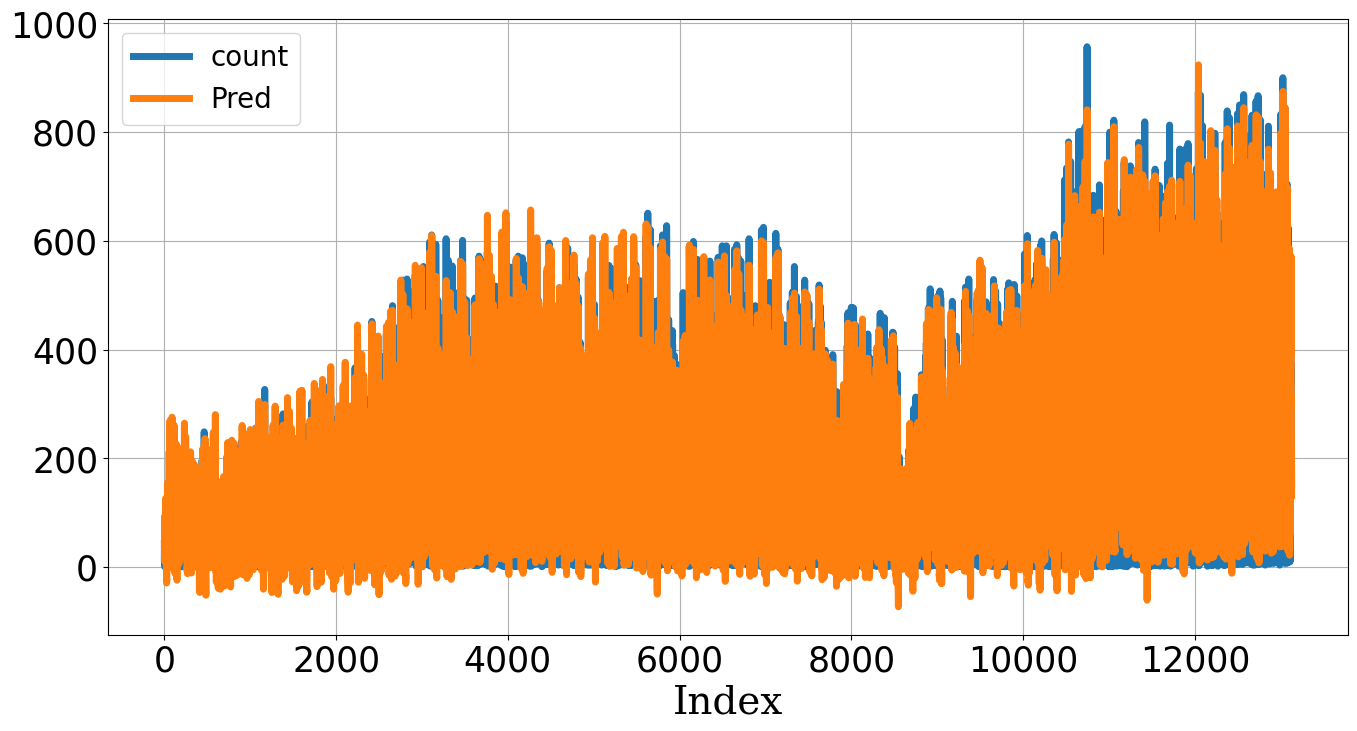

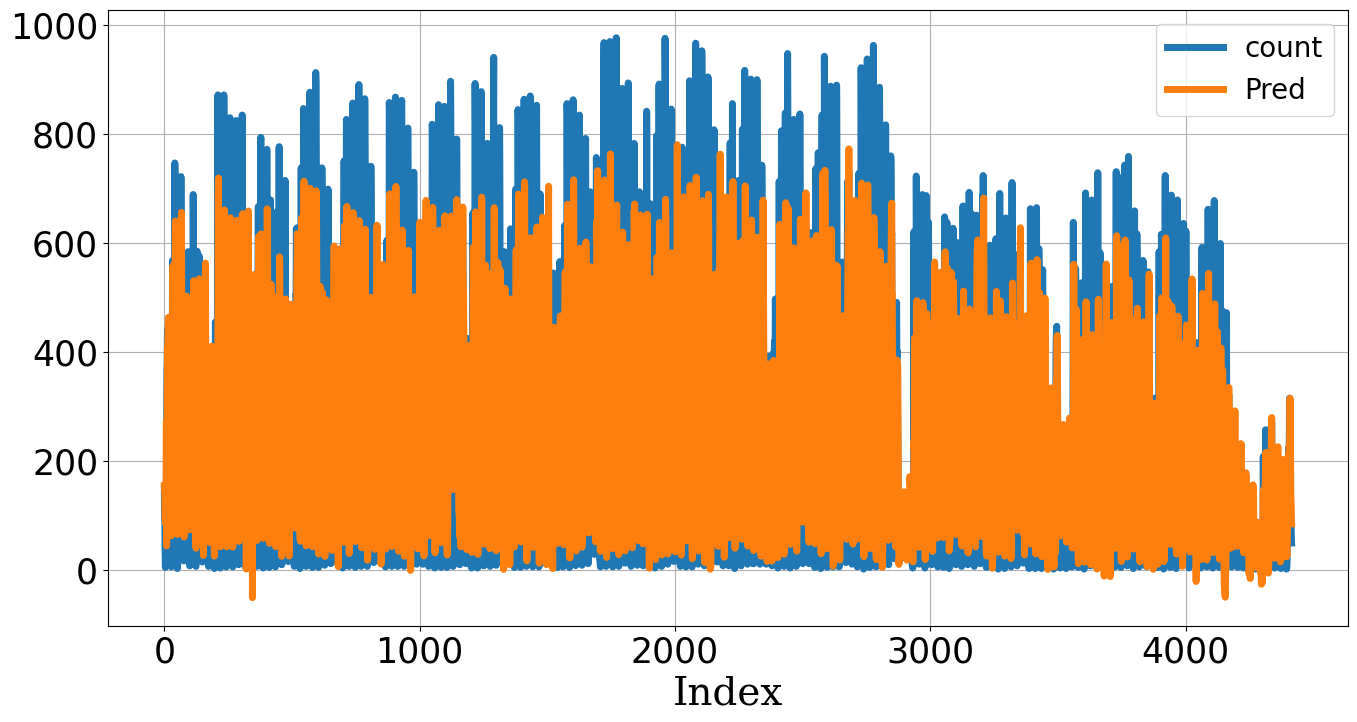

,MAE,MSE,MAPE
Train,38.41,"3,123.02",1.25
Test,113.02,"25,732.59",1.51


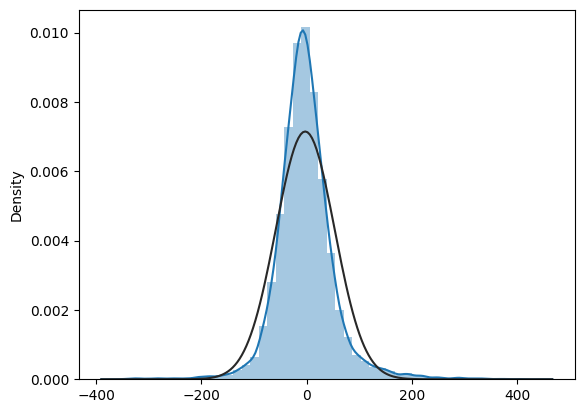

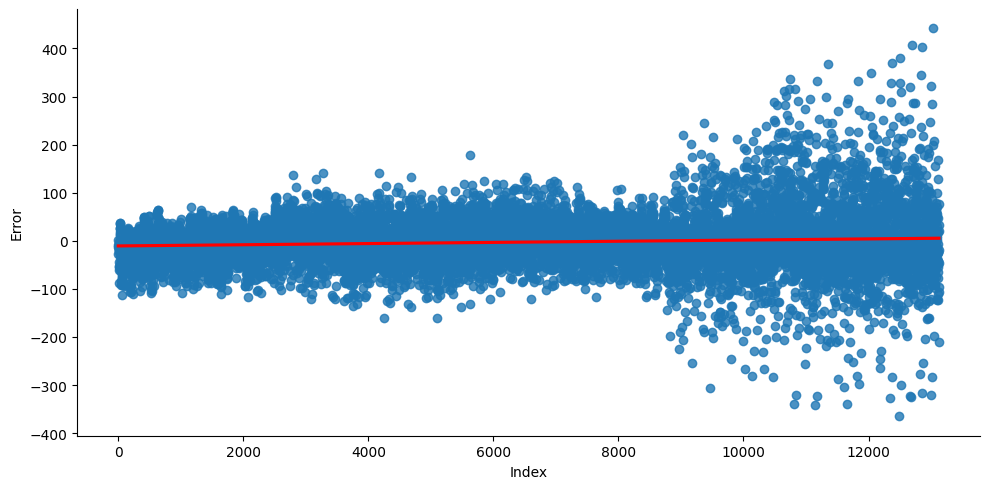

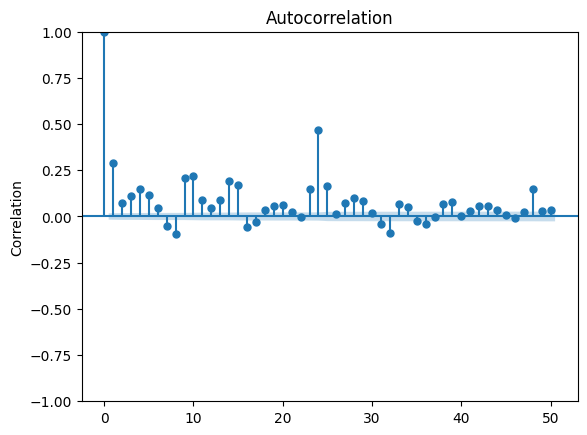

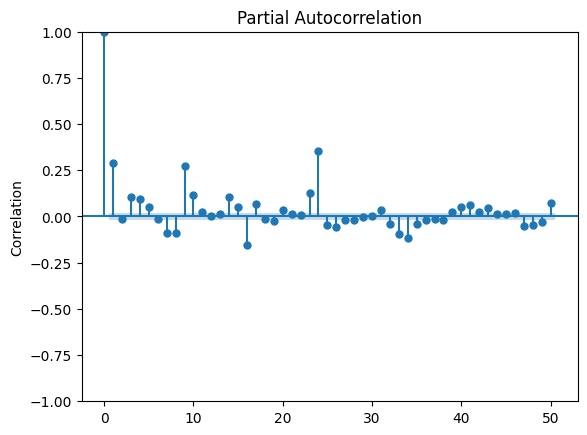

,Normality,Heteroscedasticity,Autocorr(lag10),Autocorr(lag50),Stationarity_ADF,Stationarity_KPSS
Test Statistics,0.91,"7,052.85","3,209.99","9,106.66",-12.77,2.58
p-value,0.00,0.00,0.00,0.00,0.00,0.01
Alternative,NaN,two-sided,NaN,NaN,NaN,NaN
Used Lag,NaN,NaN,NaN,NaN,41.00,26.00
Critical Value(1%),NaN,NaN,NaN,NaN,-3.43,0.74
Critical Value(5%),NaN,NaN,NaN,NaN,-2.86,0.46
Critical Value(10%),NaN,NaN,NaN,NaN,-2.57,0.35


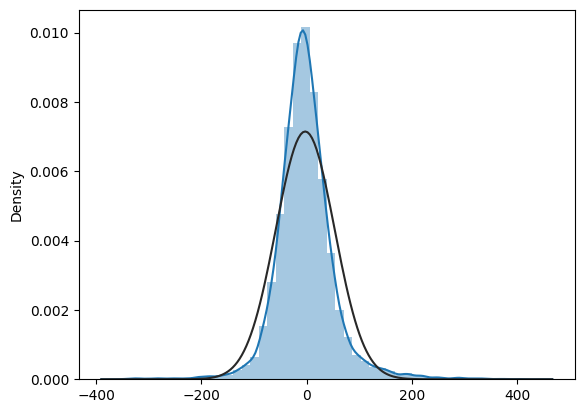

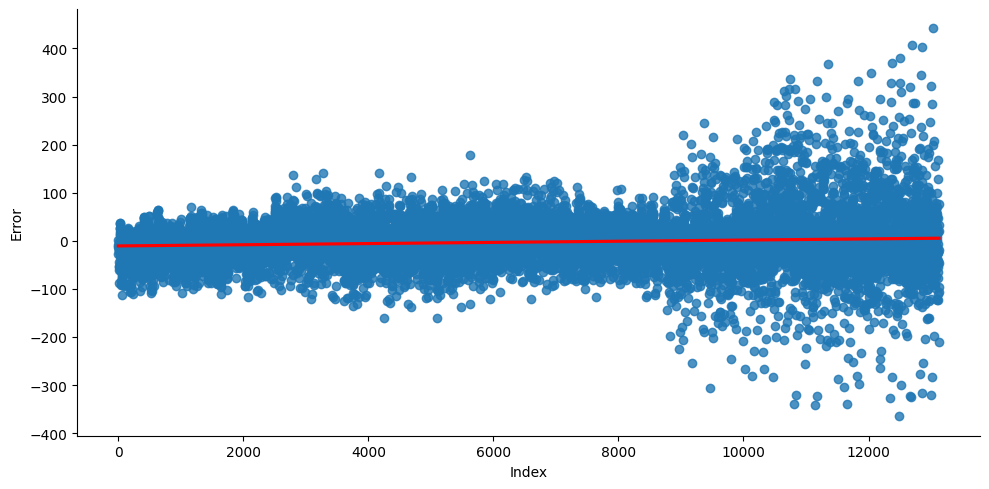

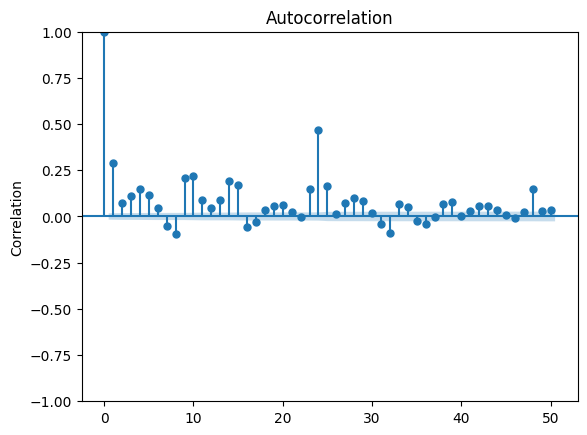

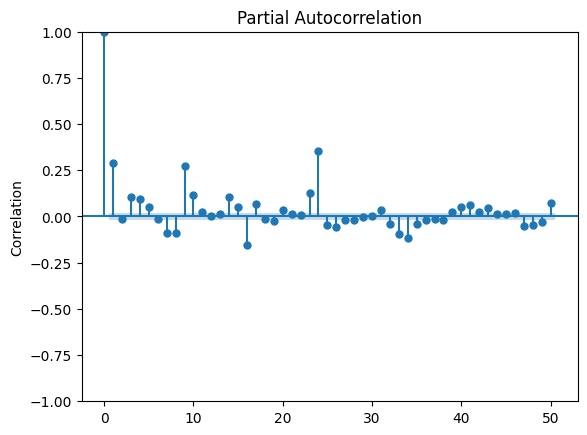

,Normality,Heteroscedasticity,Autocorr(lag10),Autocorr(lag50),Stationarity_ADF,Stationarity_KPSS
Test Statistics,0.91,"7,052.85","3,209.99","9,106.66",-12.77,2.58
p-value,0.00,0.00,0.00,0.00,0.00,0.01
Alternative,NaN,two-sided,NaN,NaN,NaN,NaN
Used Lag,NaN,NaN,NaN,NaN,41.00,26.00
Critical Value(1%),NaN,NaN,NaN,NaN,-3.43,0.74
Critical Value(5%),NaN,NaN,NaN,NaN,-2.86,0.46
Critical Value(10%),NaN,NaN,NaN,NaN,-2.57,0.35


In [55]:
# 데이터 로딩
location = os.path.join('.', 'data', 'Bike_Sharing_Demand_Full.csv')
df_all = pd.read_csv(location)

# 데이터 전처리
df_fe = feature_engineering(df_all)

# 데이터 분리
Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in df_fe.columns if x not in Y_colname+X_remove]
X_train, X_test, Y_train, Y_test = datasplit_ts(df_fe, Y_colname, X_colname, '2012-07-01')

# 데이터 전처리(현실성)
### Reality ###
target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
X_train_R, X_test_R = feature_engineering_year_duplicated(X_train, X_test, target)
target = ['count_lag1', 'count_lag2']
X_test_R = feature_engineering_lag_modified(Y_test, X_test_R, target)
###############
### Scaling ###
X_train_RS, X_test_RS = feature_engineering_scaling(preprocessing.MinMaxScaler(), X_train_R, X_test_R)
###############


# Linear Regression
model_lr_RS = sm.OLS(Y_train, X_train_RS).fit()
display(model_lr_RS.summary())

Y_trpred_RS = pd.DataFrame(model_lr_RS.predict(X_train_RS), columns=['Pred'])
Y_tepred_RS = pd.DataFrame(model_lr_RS.predict(X_test_RS), columns=['Pred'])
plot_prediction(pd.concat([Y_train, Y_trpred_RS], axis=1).reset_index().iloc[:,1:])
plot_prediction(pd.concat([Y_test, Y_tepred_RS], axis=1).reset_index().iloc[:,1:])

# 분석 검증
Score_RS = evaluation_reg_trte(Y_train, Y_trpred_RS, Y_test, Y_tepred_RS)
display(Score_RS)

# 에러 분석
Resid_tr = Y_train - Y_trpred_RS.values
Resid_tr.columns = ['Error']
Resid_te = Y_test - Y_tepred_RS.values
Resid_te.columns = ['Error']

Error_tr_RS = error_analysis_timeseries(X_train, Y_trpred, Resid_tr, graph_on=True)
display(Error_tr_RS)
Error_te_RS = error_analysis_timeseries(X_train, Y_trpred, Resid_tr, graph_on=True)
display(Error_te_RS)

In [56]:
# 전처리 결과에 따른 성능 비교
display(Score_Raw)
display(Score_FEHalf)
display(Score_R)
display(Score_RS)

,MAE,MSE,MAPE
Train,103.09,"19,360.42",4.58
Test,150.03,"43,410.27",3.17


,MAE,MSE,MAPE
Train,0.01,0.04,0.00
Test,0.01,0.00,0.00


,MAE,MSE,MAPE
Train,27.79,"2,364.05",0.82
Test,113.99,"26,316.17",1.34


,MAE,MSE,MAPE
Train,38.41,"3,123.02",1.25
Test,113.02,"25,732.59",1.51
